# DROPSINATOR


## Import

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from lmfit.models import GaussianModel

from scipy.signal import find_peaks
from scipy import optimize as optim

import uncertainties as unc


import sys
sys.path.append('../Library')

import drop_detection_tools as ddt
import uplotlib as uplt


plot_dir = '../../../Report/Plots/'
result_dir = '../../../T-data/Results/'

plot_dir.rstrip('/')
result_dir.rstrip('/')

from importlib import reload


from tqdm import tqdm
%matplotlib inline
import csv

## Latex plot

In [2]:
FontSize = 18
plt.rc('axes',   titlesize = FontSize) # fontsize of the axes title
plt.rc('axes',   labelsize = FontSize) # fontsize of the x and y labels
plt.rc('xtick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('ytick',  labelsize = FontSize) # fontsize of the tick labels
plt.rc('legend', fontsize  = FontSize) # legend fontsize
plt.rc('figure', titlesize = FontSize) # fontsize of the figure title

matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' :  18,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Data acquisition

name = '2-12_B-ol10-aq10'


<IPython.core.display.Javascript object>


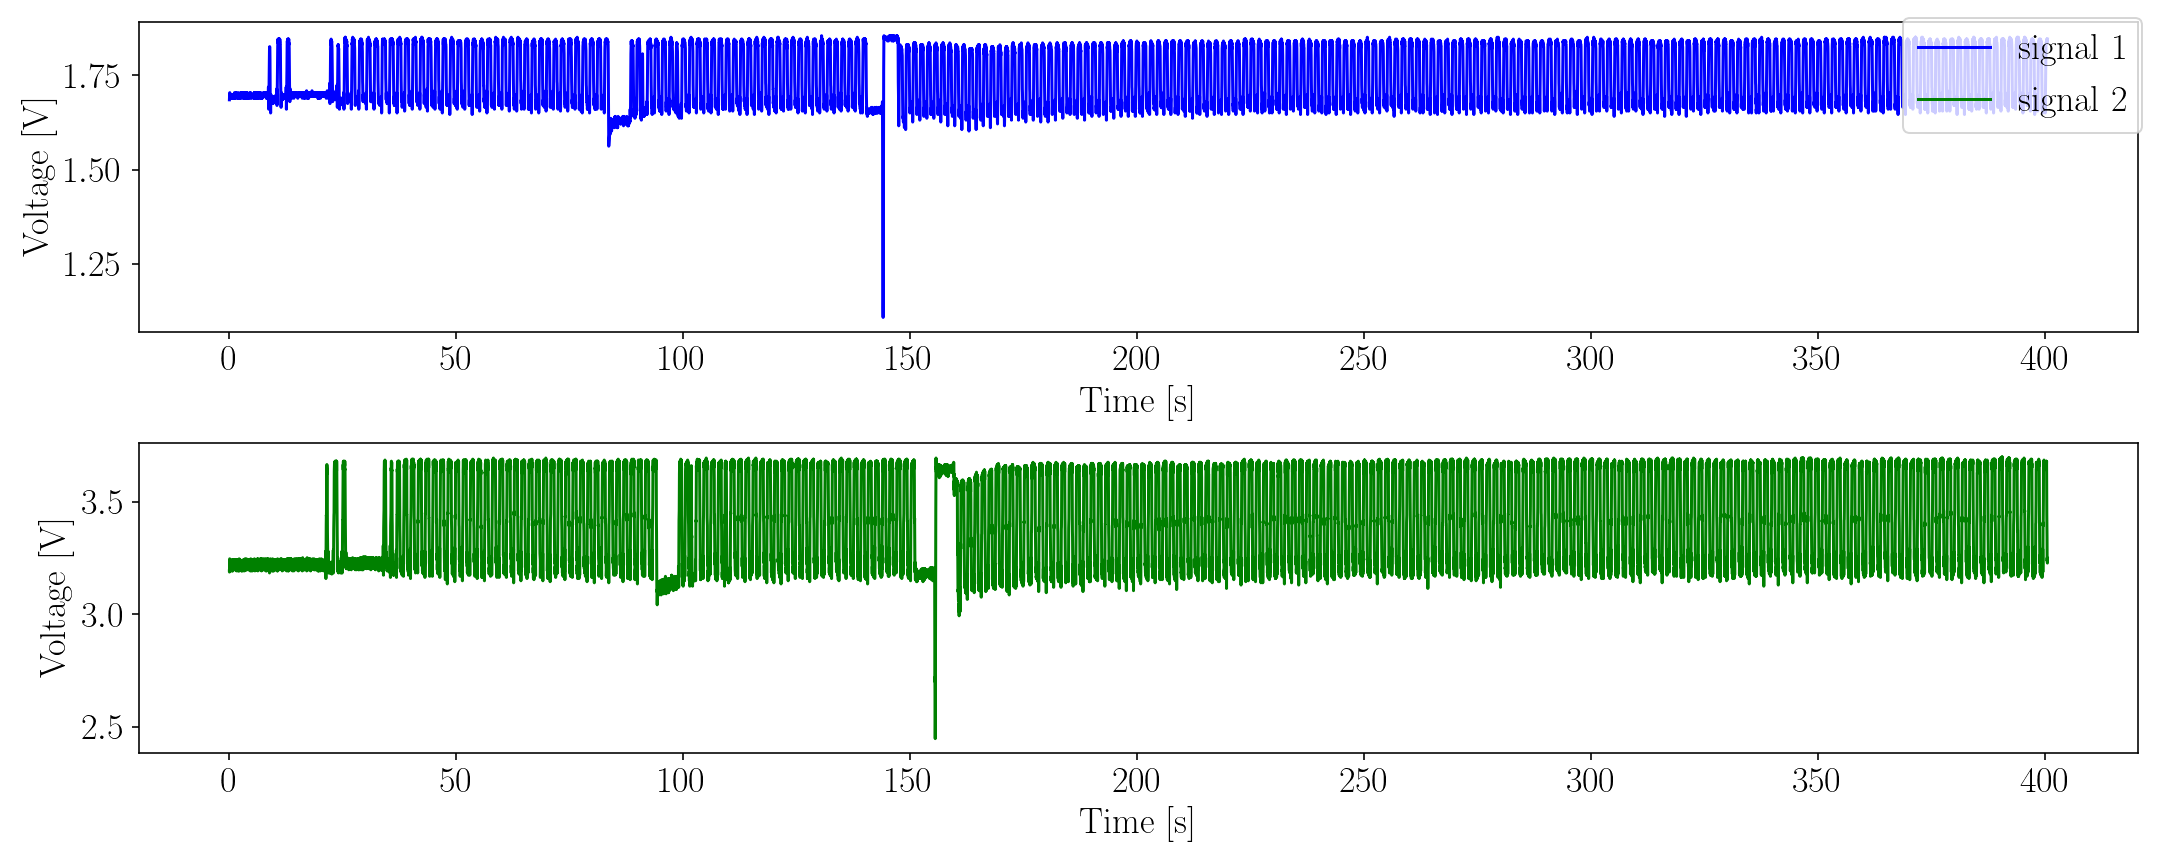

../Library/drop_detection_tools.py:55: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best')


In [3]:
#************************************
folder   = '../../../T-data/2-12/'
filename = 'B-ol10-aq10-pause10.csv'

fol_name = folder.rstrip('/').rsplit('/', 1)[1]

name     = fol_name + '_' + filename.rsplit('-',1)[0]
print(f'{name = }')
#************************************

raw = True 
%matplotlib notebook
%matplotlib notebook
sig1, sig2, t_raw = ddt.read_LV(folder, filename)

## Resample data

In [4]:
valid_indices=np.where(t_raw>148.5)
sig1=sig1[valid_indices]
sig2=sig2[valid_indices]
t_raw=t_raw[valid_indices]

<IPython.core.display.Javascript object>


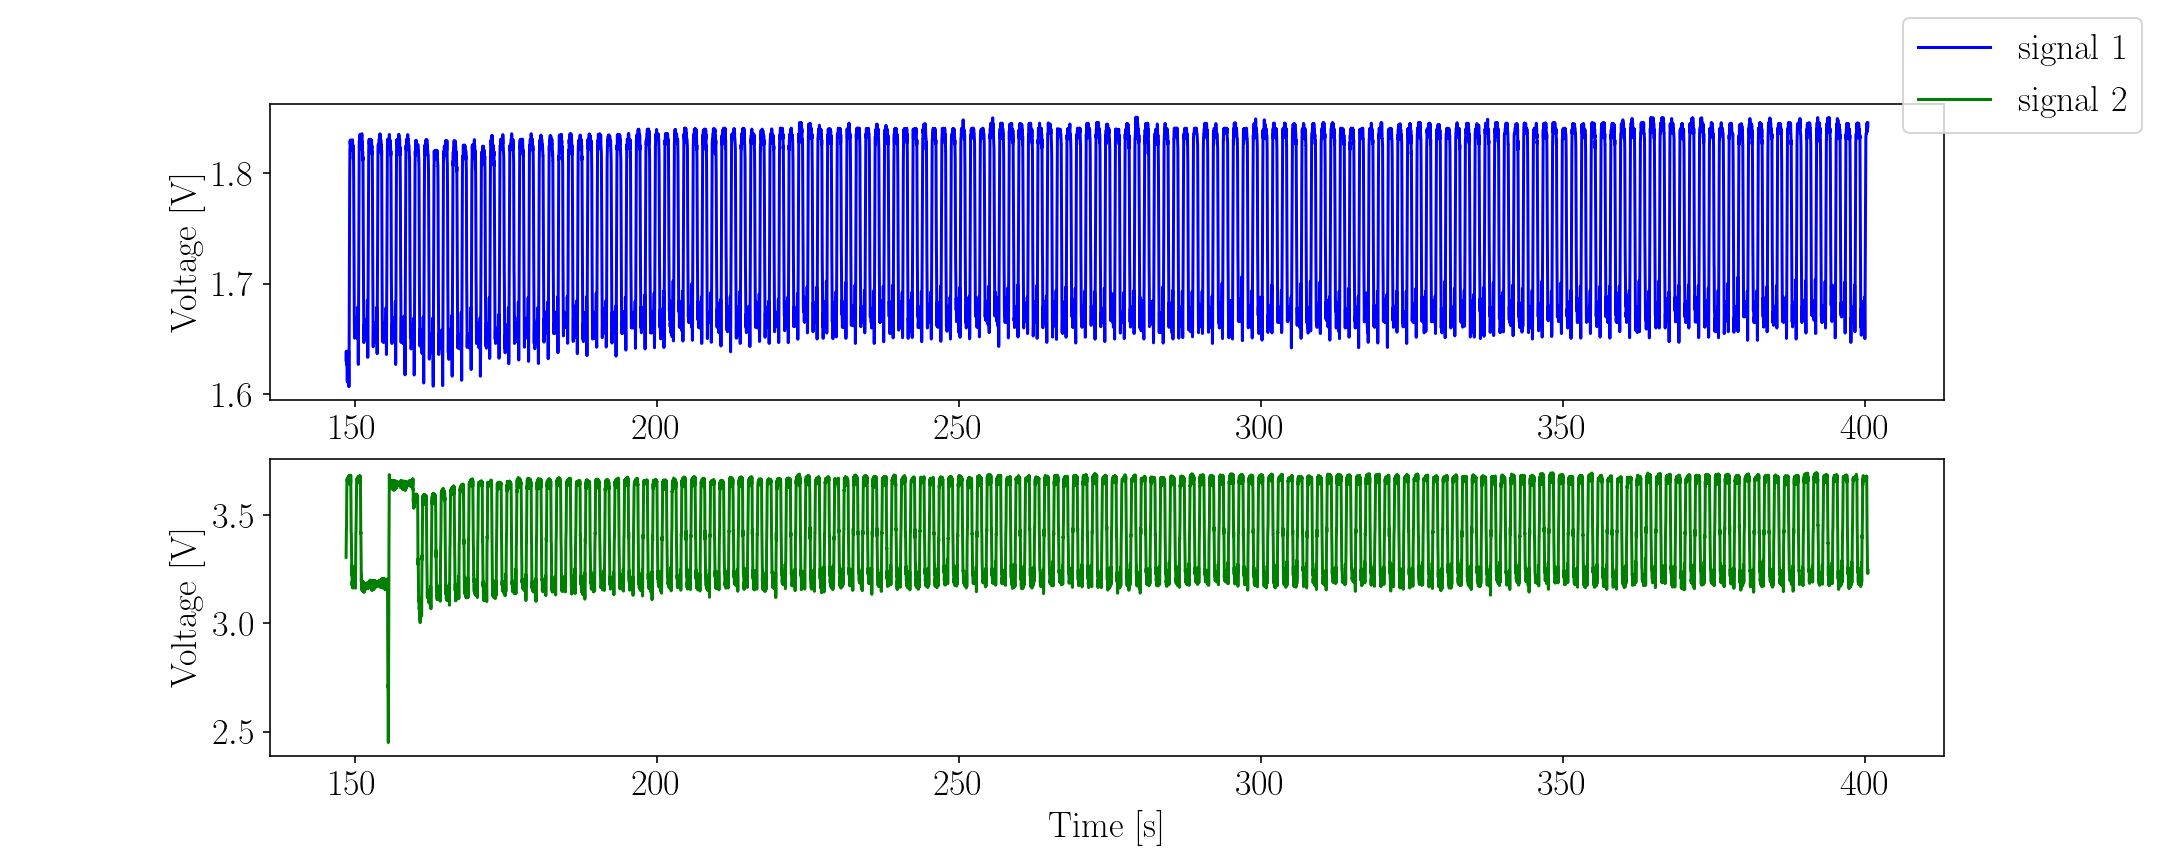

<ipython-input-5-2c55b89d88de>:22: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(loc='best')


In [5]:
#******************************
dt = 0.01  # sampling time [s]
#******************************

# Resampling of the two signals
if raw:
    sig1, new_t = ddt.resample(sig1, t_raw, dt=dt)
    sig2, _     = ddt.resample(sig2, t_raw, dt=dt)
    t           = new_t
    raw         = False 
else:
    print('data already resampled')

    
# Signals plots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,6))
axs[0].plot(t, sig1, color='blue', label= "signal 1")
axs[0].set_ylabel('Voltage [V]')
axs[1].plot(t, sig2, color='green', label= "signal 2")
axs[1].set_ylabel('Voltage [V]')
axs[1].set_xlabel('Time [s]')
fig.legend(loc='best')

## Fourier transform


In [6]:
min_freq  = 1       # lower cut-off frequency
max_freq  = 5000   # higher cut-off frequency

### Signal 1 

<IPython.core.display.Javascript object>


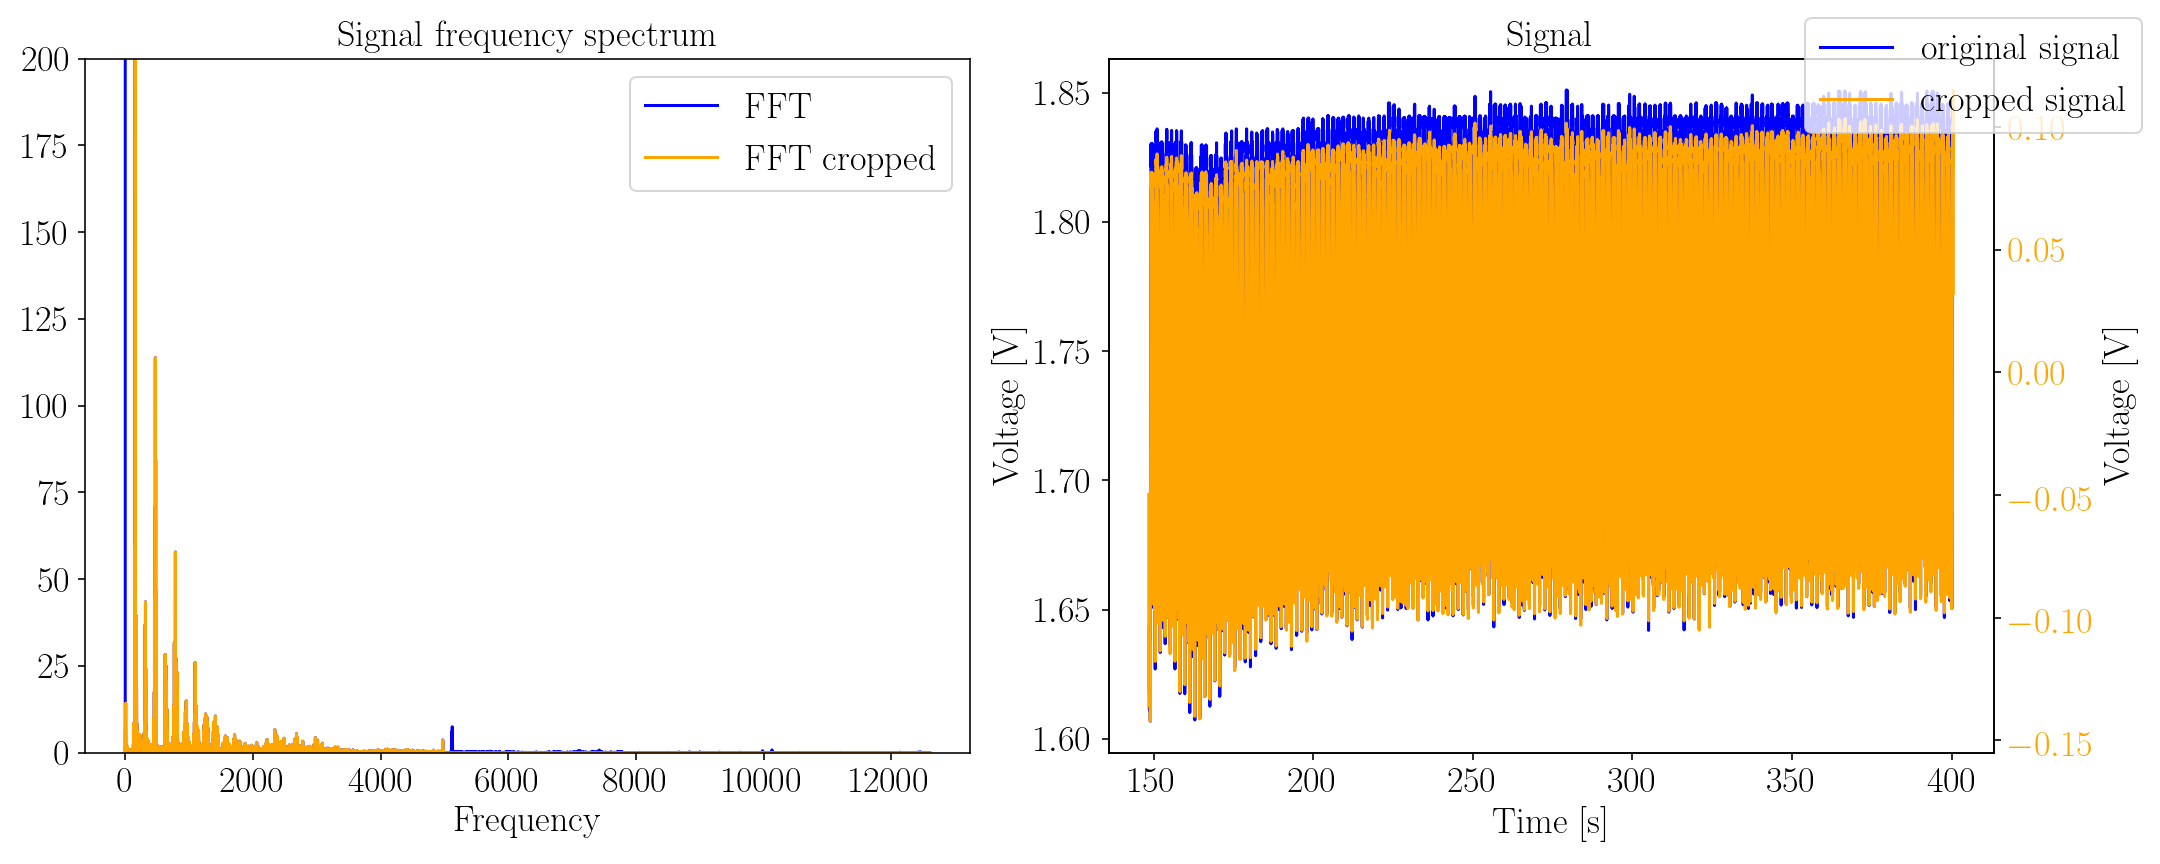

/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
../Library/drop_detection_tools.py:291: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  legend = fig.legend(['original signal','cropped signal'], loc='best')


In [7]:
sig1_high = ddt.FFT_cropping(sig1, t, min_freq, max_freq)

### Signal 2 

<IPython.core.display.Javascript object>


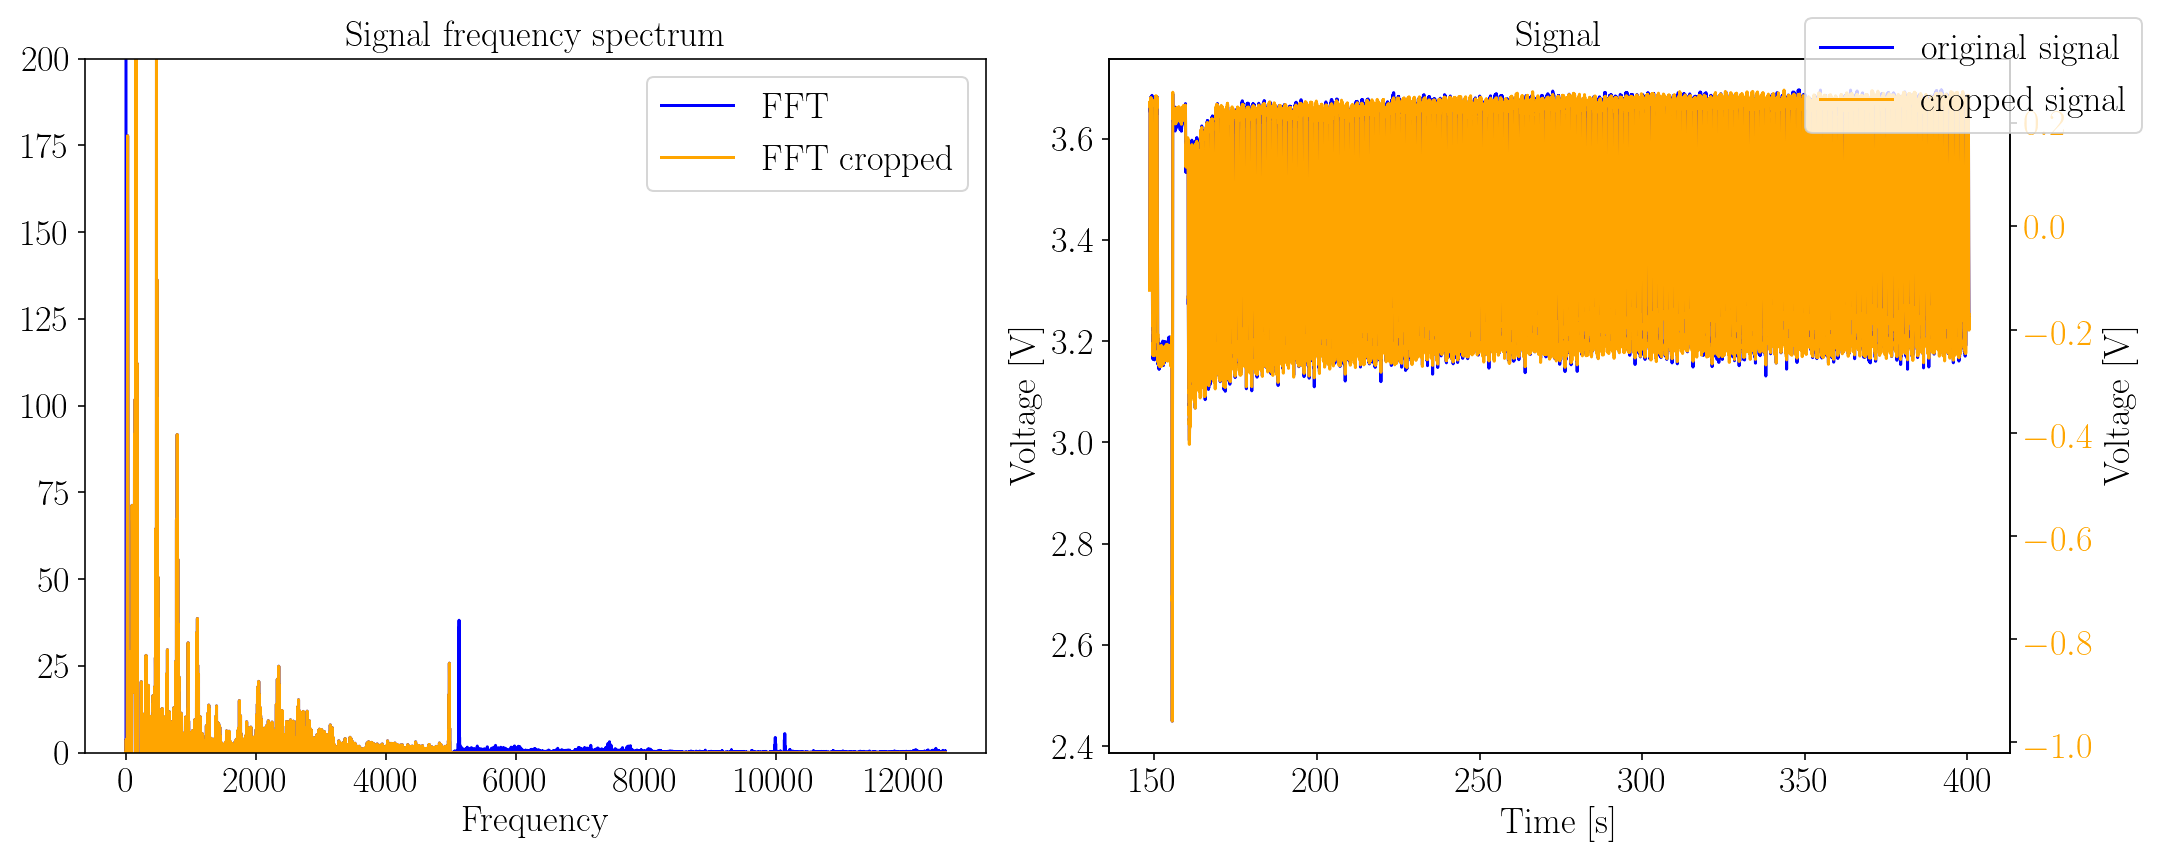

/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/alessandro/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
../Library/drop_detection_tools.py:291: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  legend = fig.legend(['original signal','cropped signal'], loc='best')


In [8]:
sig2_high = ddt.FFT_cropping(sig2, t, min_freq, max_freq)

## Signal Rectify

### Signal 1 

In [124]:
sig1_r = sig1_high
sig2_r = sig2_high

100%|██████████| 25203/25203 [00:01<00:00, 18219.52it/s]


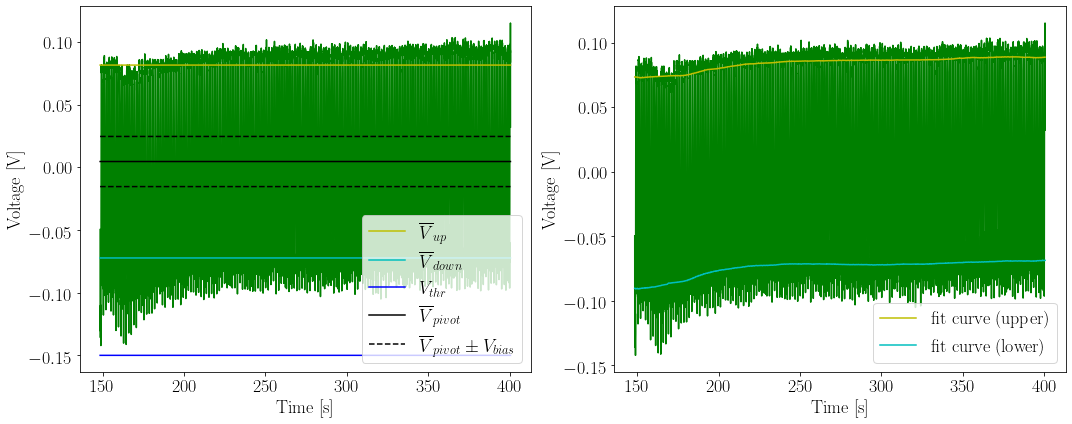

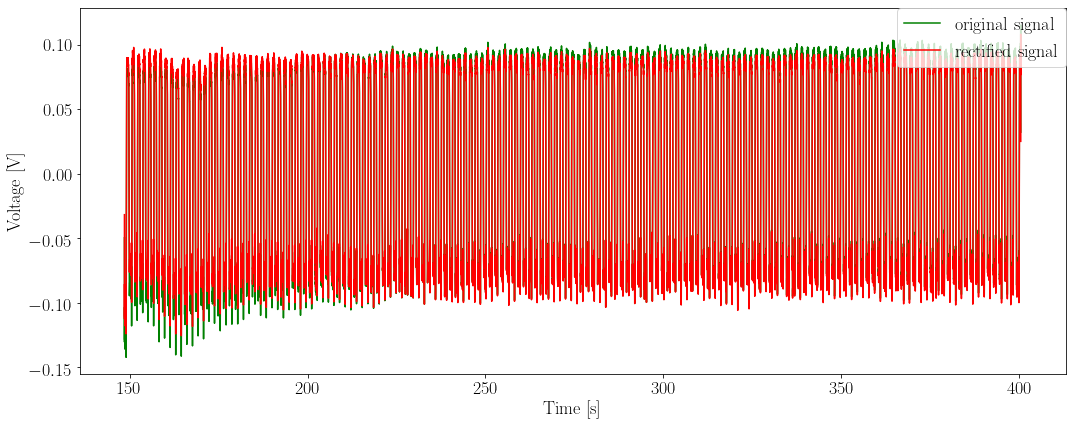

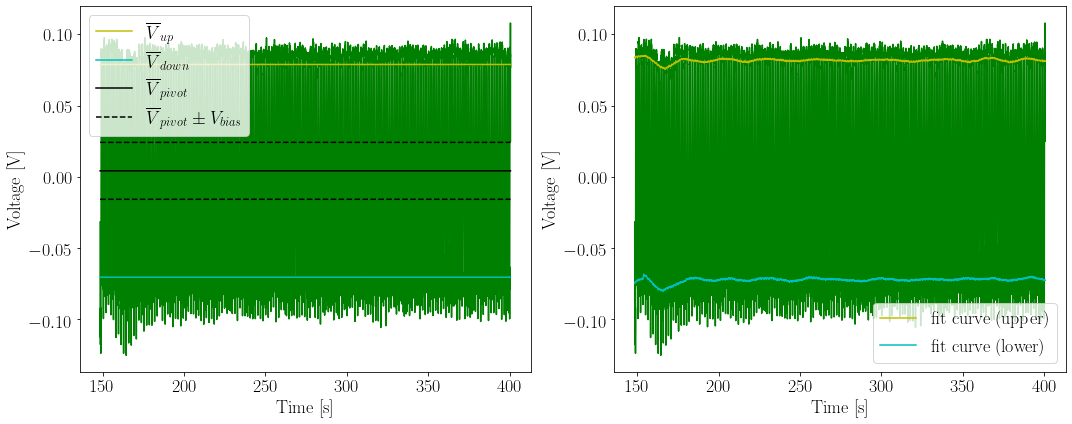

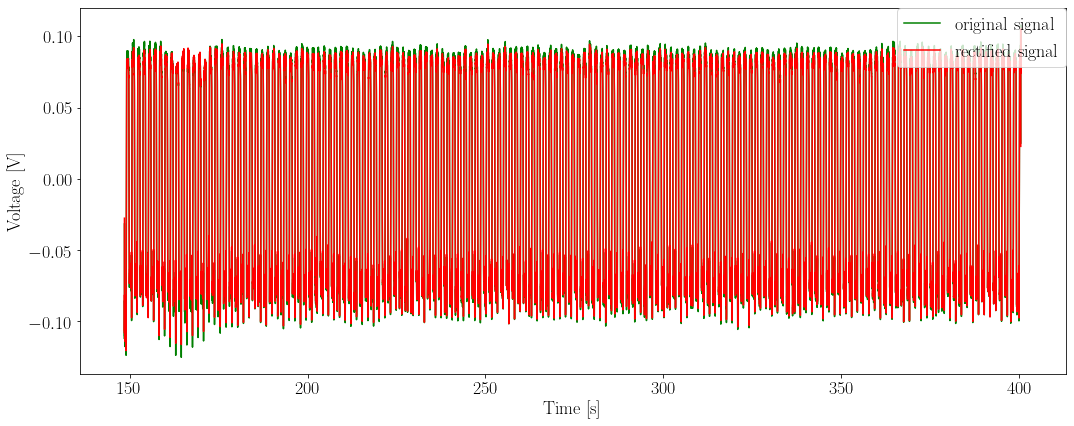

In [9]:
%matplotlib inline

fig, sig1_r = ddt.rectify_new(sig1_high, xrange=20, xdata=t, ignore_bias=0.02, manual_thr=-0.15)

fig, sig1_r = ddt.rectify_new(sig1_r, xrange=5, xdata=t, ignore_bias=0.02, manual_thr=-0.15)

### Signal 2

100%|██████████| 25203/25203 [00:01<00:00, 19155.55it/s]


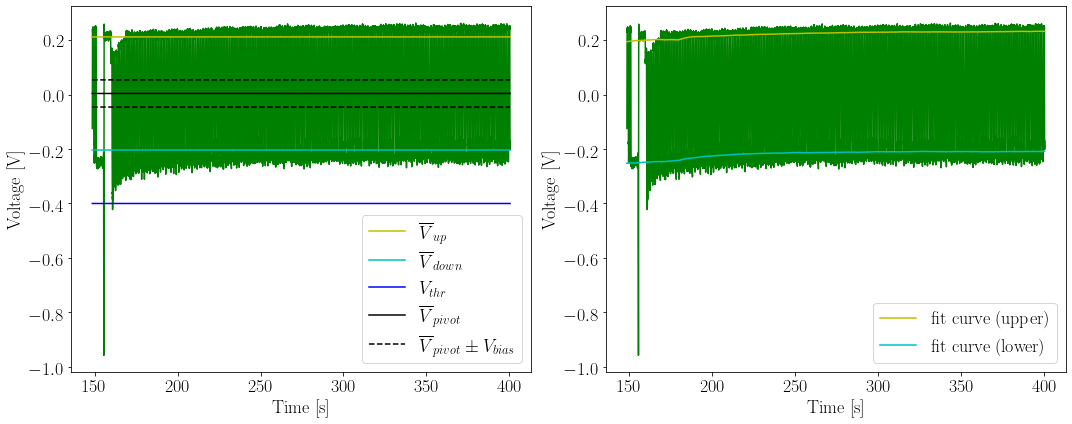

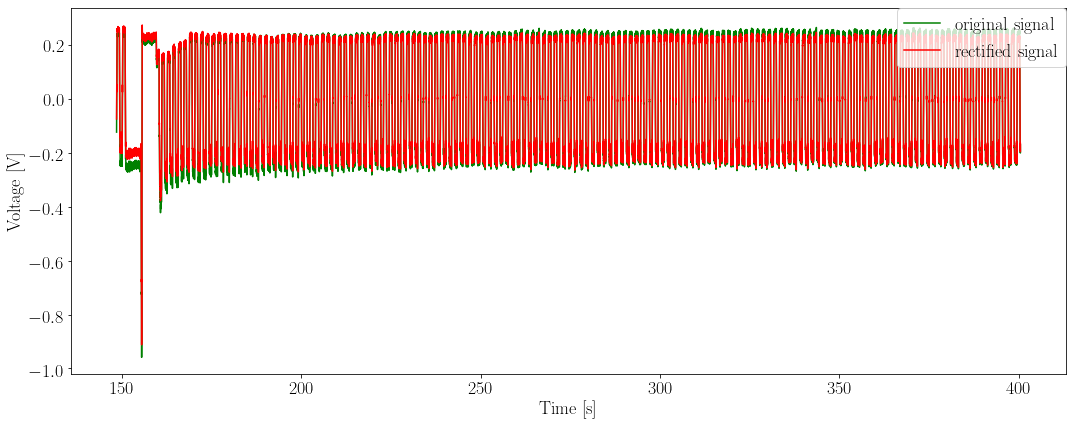

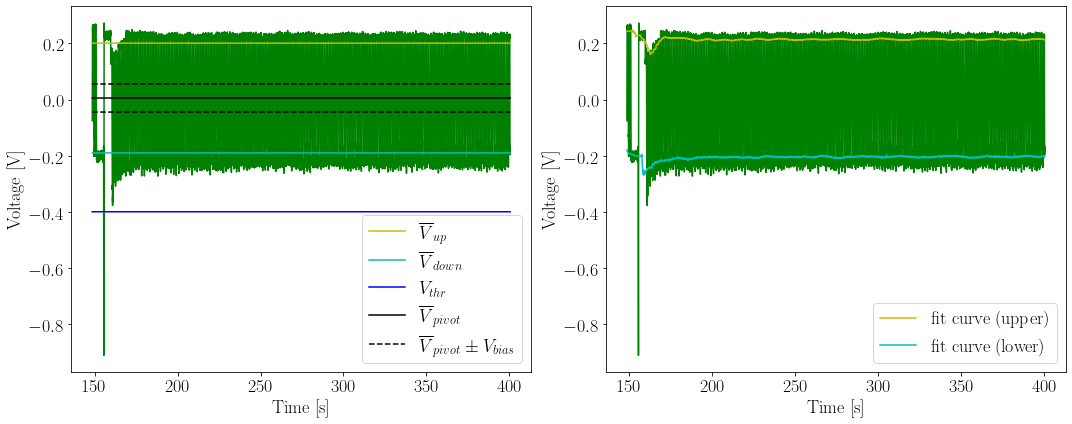

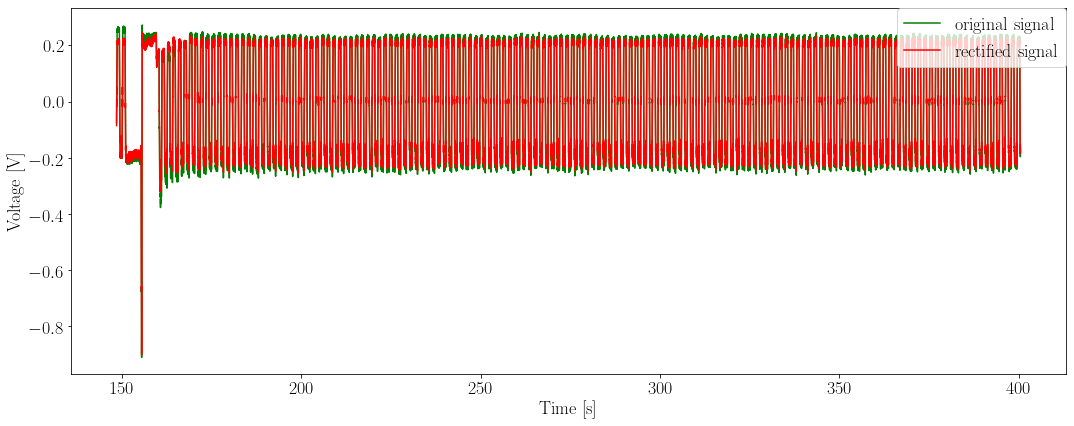

In [10]:
fig, sig2_r = ddt.rectify_new(sig2_high, xrange=20, xdata=t, ignore_bias=0.05, manual_thr=-0.4)

fig, sig2_r = ddt.rectify_new(sig2_r, xrange=3, xdata=t, ignore_bias=0.05, manual_thr=-0.4)

## Thresholds computing

### Signal 1

<IPython.core.display.Javascript object>


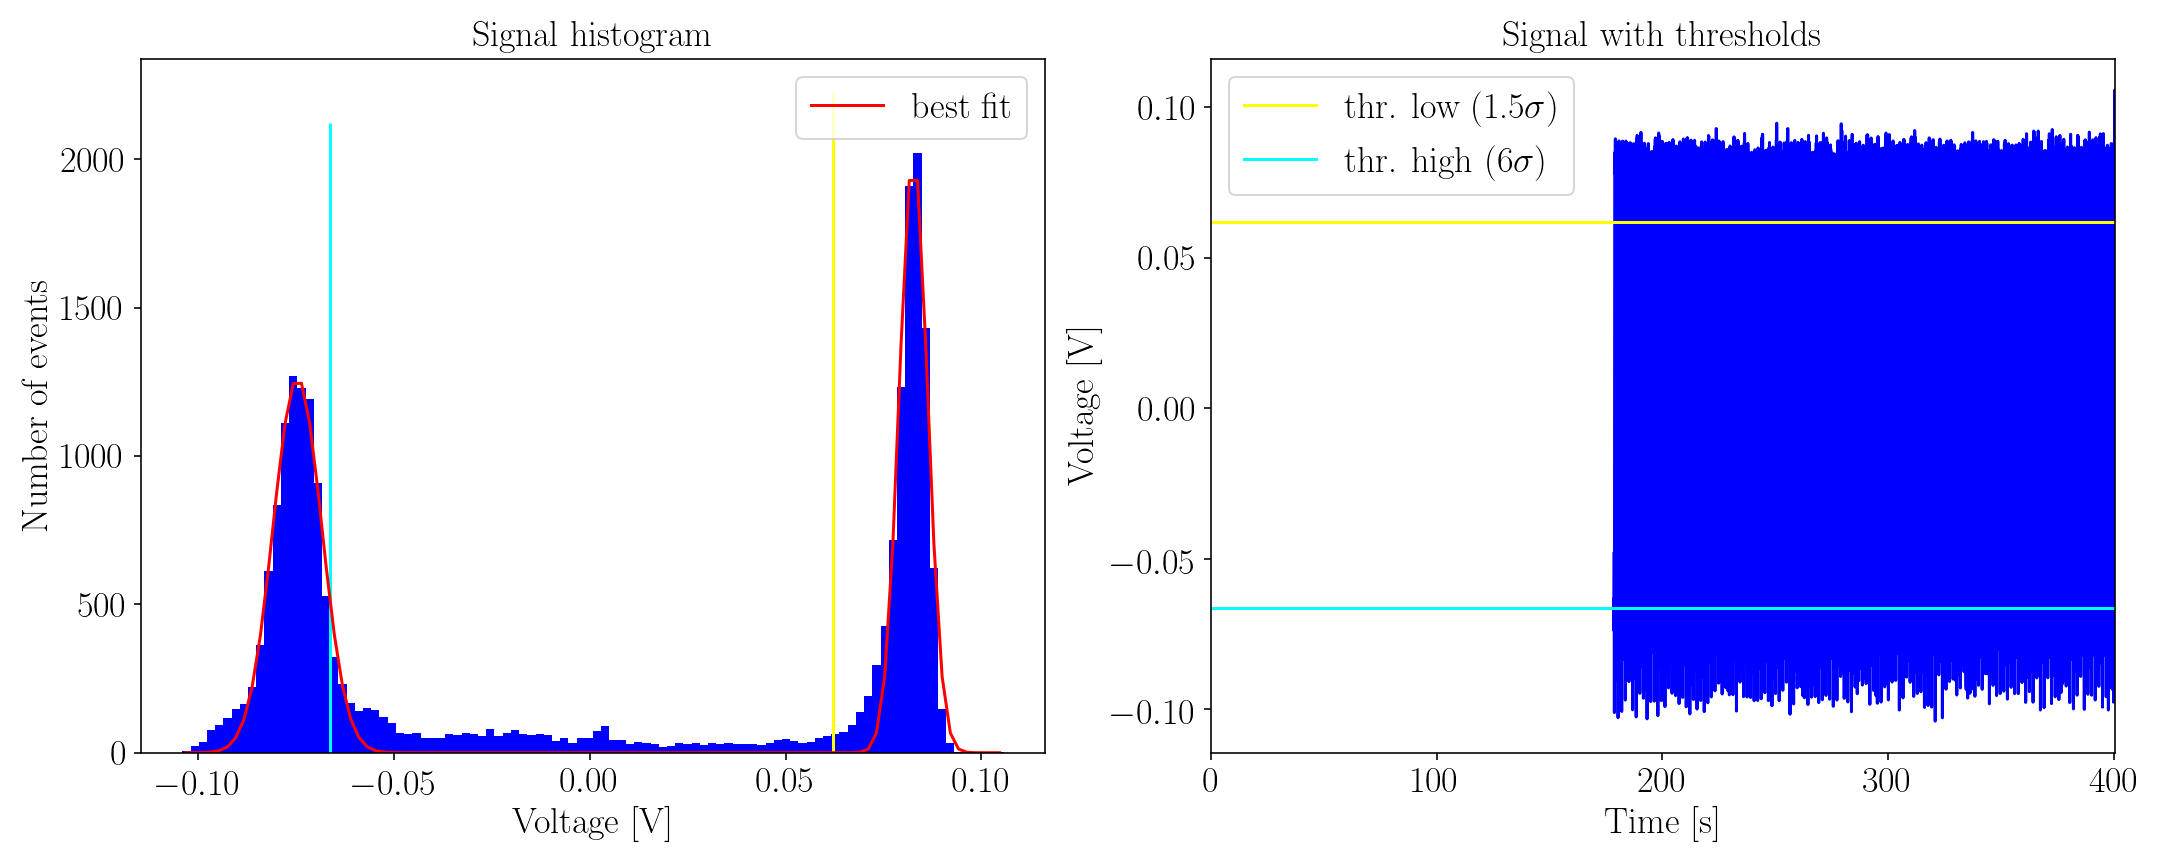

In [12]:
%matplotlib notebook 
# %matplotlib inline
thr_low_1, thr_high_1, sigma_low_1, sigma_high_1 = ddt.thr_searcher(sig1_r[3000:], 100,
                                         high_sigmas=6, low_sigmas=1.5, Xdata=t[3000:],
                                         color='blue', xlabel='Time [s]', ylabel='Voltage [V]')

### Signal 2

<IPython.core.display.Javascript object>


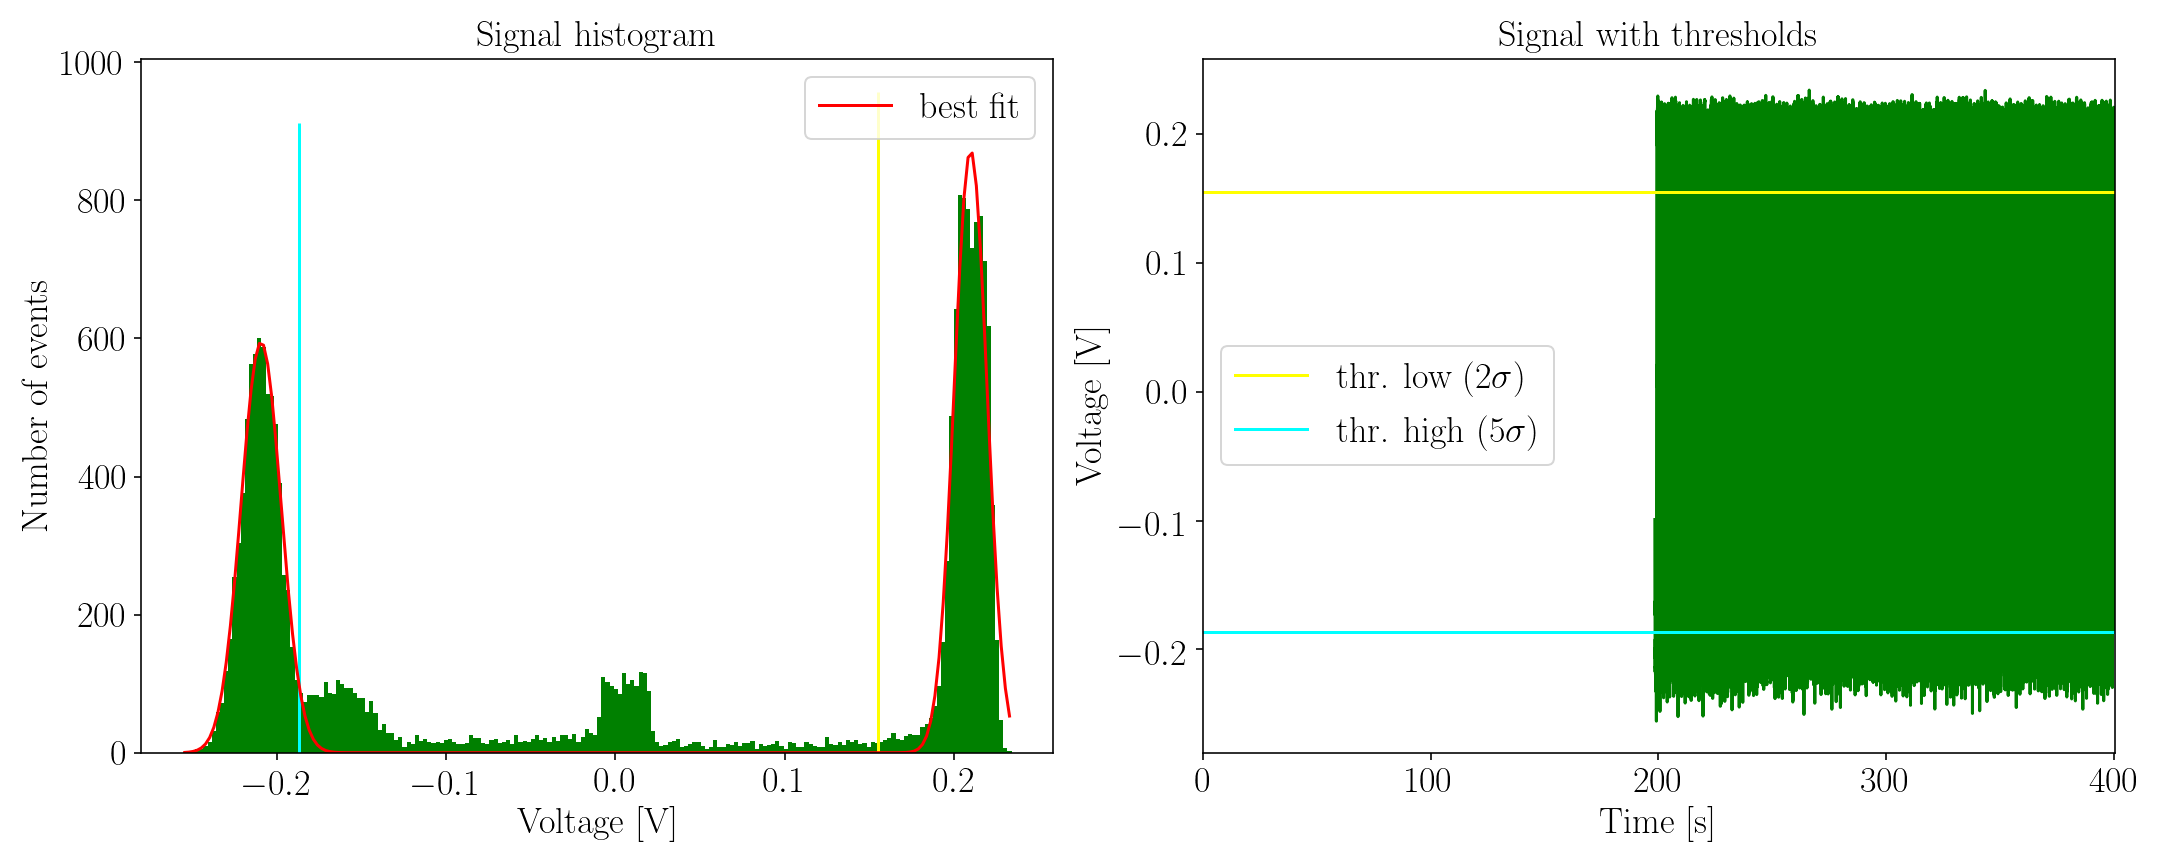

In [13]:
%matplotlib notebook
# %matplotlib inline
thr_low_2, thr_high_2, sigma_low_2, sigma_high_2 = ddt.thr_searcher(sig2_r[5000:], 200, low_sigmas=2, high_sigmas=5, Xdata=t[5000:],
                                         color='green', xlabel='Time [s]', ylabel='Voltage [V]')

## Drops detection

### Signal 1

In [47]:
reload(ddt)

<module 'drop_detection_tools' from '../Library/drop_detection_tools.py'>

157 157 157 157
149.10199999999946  Couldn't find wide start, inserting a fake one
155.29199999999383  missed previous wide end: trying to adjust
163.04199999998679  missed previous wide end: trying to adjust
167.7519999999825  missed previous wide end: trying to adjust
169.32199999998107  missed previous wide end: trying to adjust
173.95199999997686  missed previous wide end: trying to adjust
175.5719999999754  missed previous wide end: trying to adjust
180.47199999997093  missed previous wide end: trying to adjust
196.54199999995632  missed previous wide end: trying to adjust
199.69199999995345  missed previous wide end: trying to adjust
209.11199999994489  missed previous wide end: trying to adjust
220.26199999993474  missed previous wide end: trying to adjust
223.43199999993186  missed previous wide end: trying to adjust
232.9619999999232  missed previous wide end: trying to adjust
234.52199999992177  missed previous wide end: trying to adjust
236.09199999992035  missed previous wi

<IPython.core.display.Javascript object>


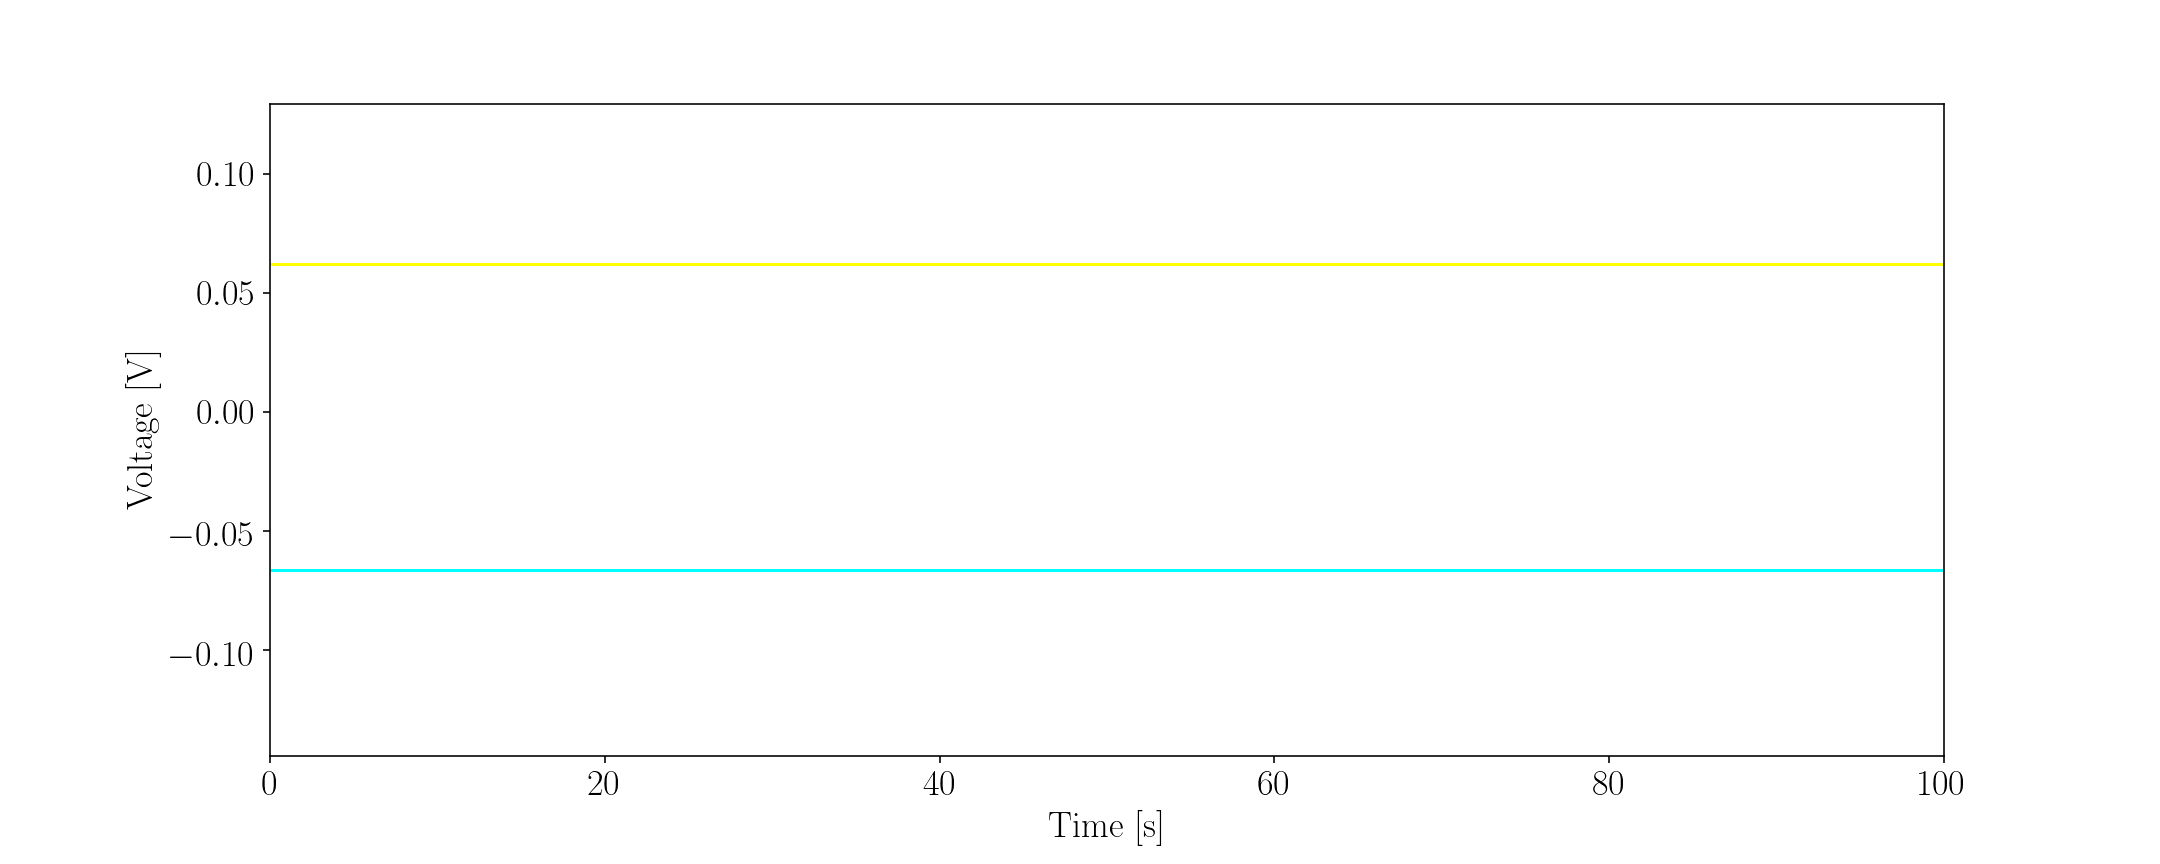

<IPython.core.display.Javascript object>


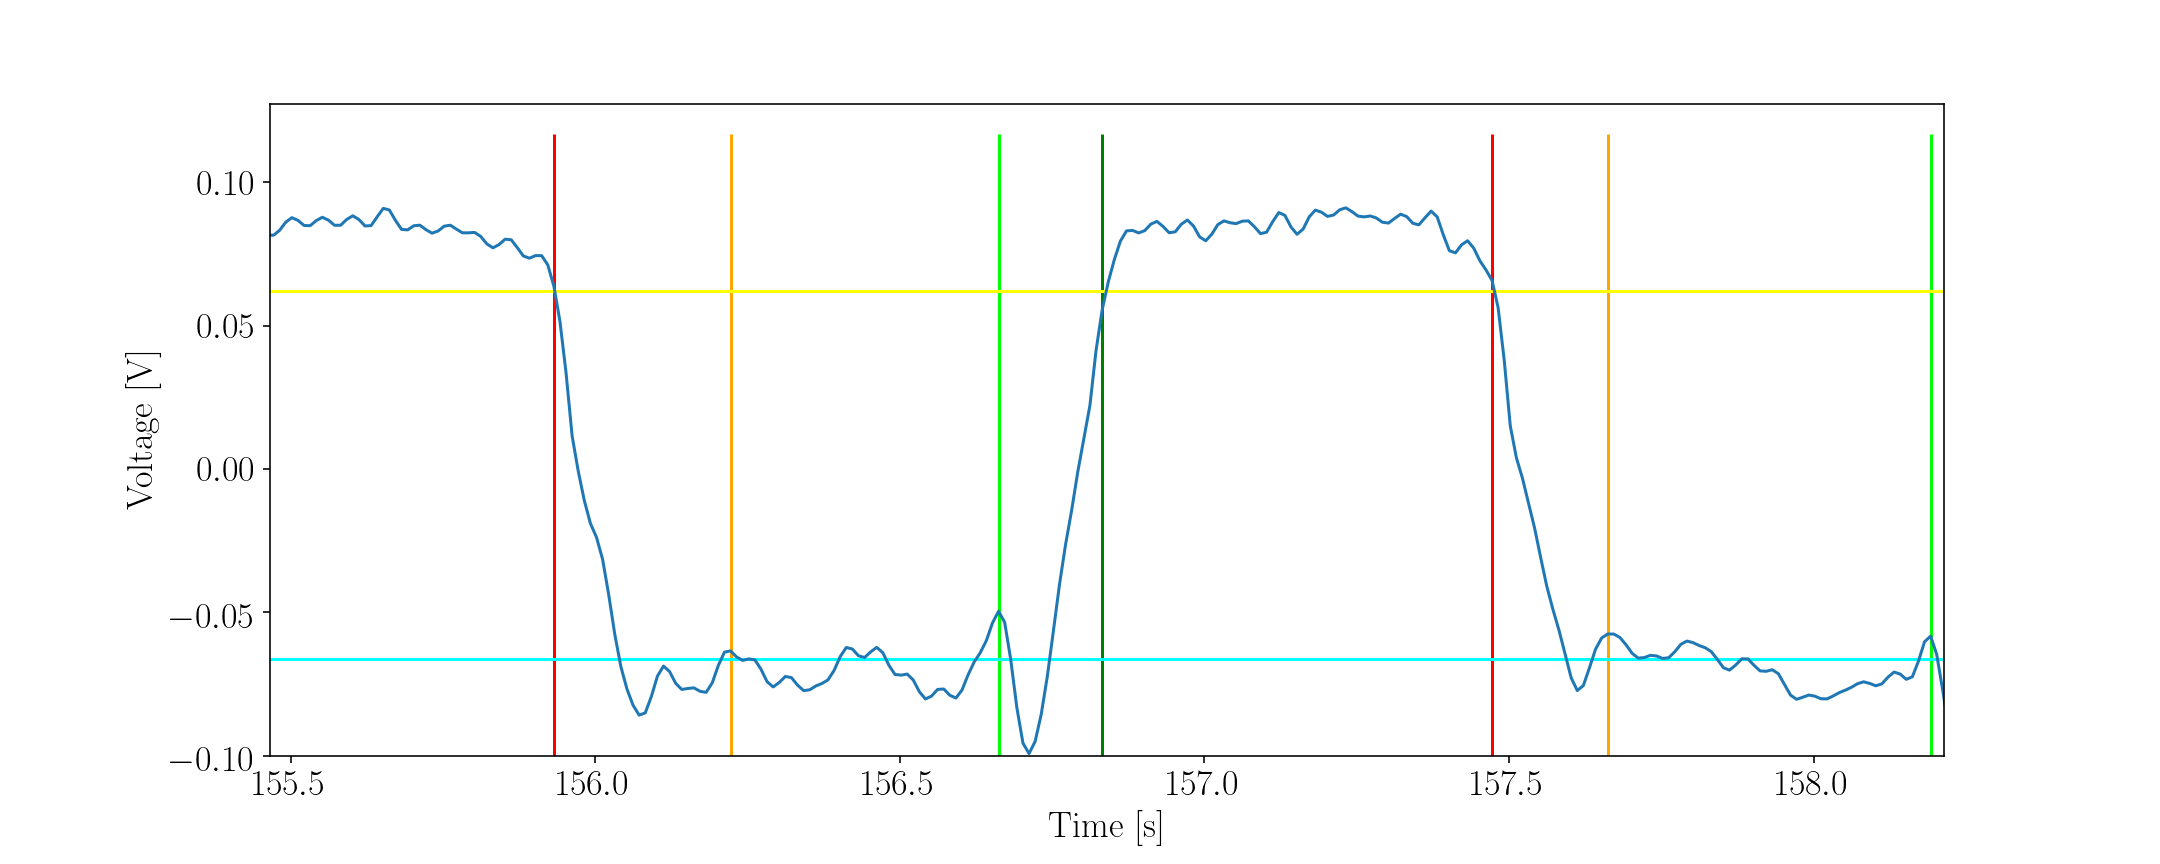

<IPython.core.display.Javascript object>


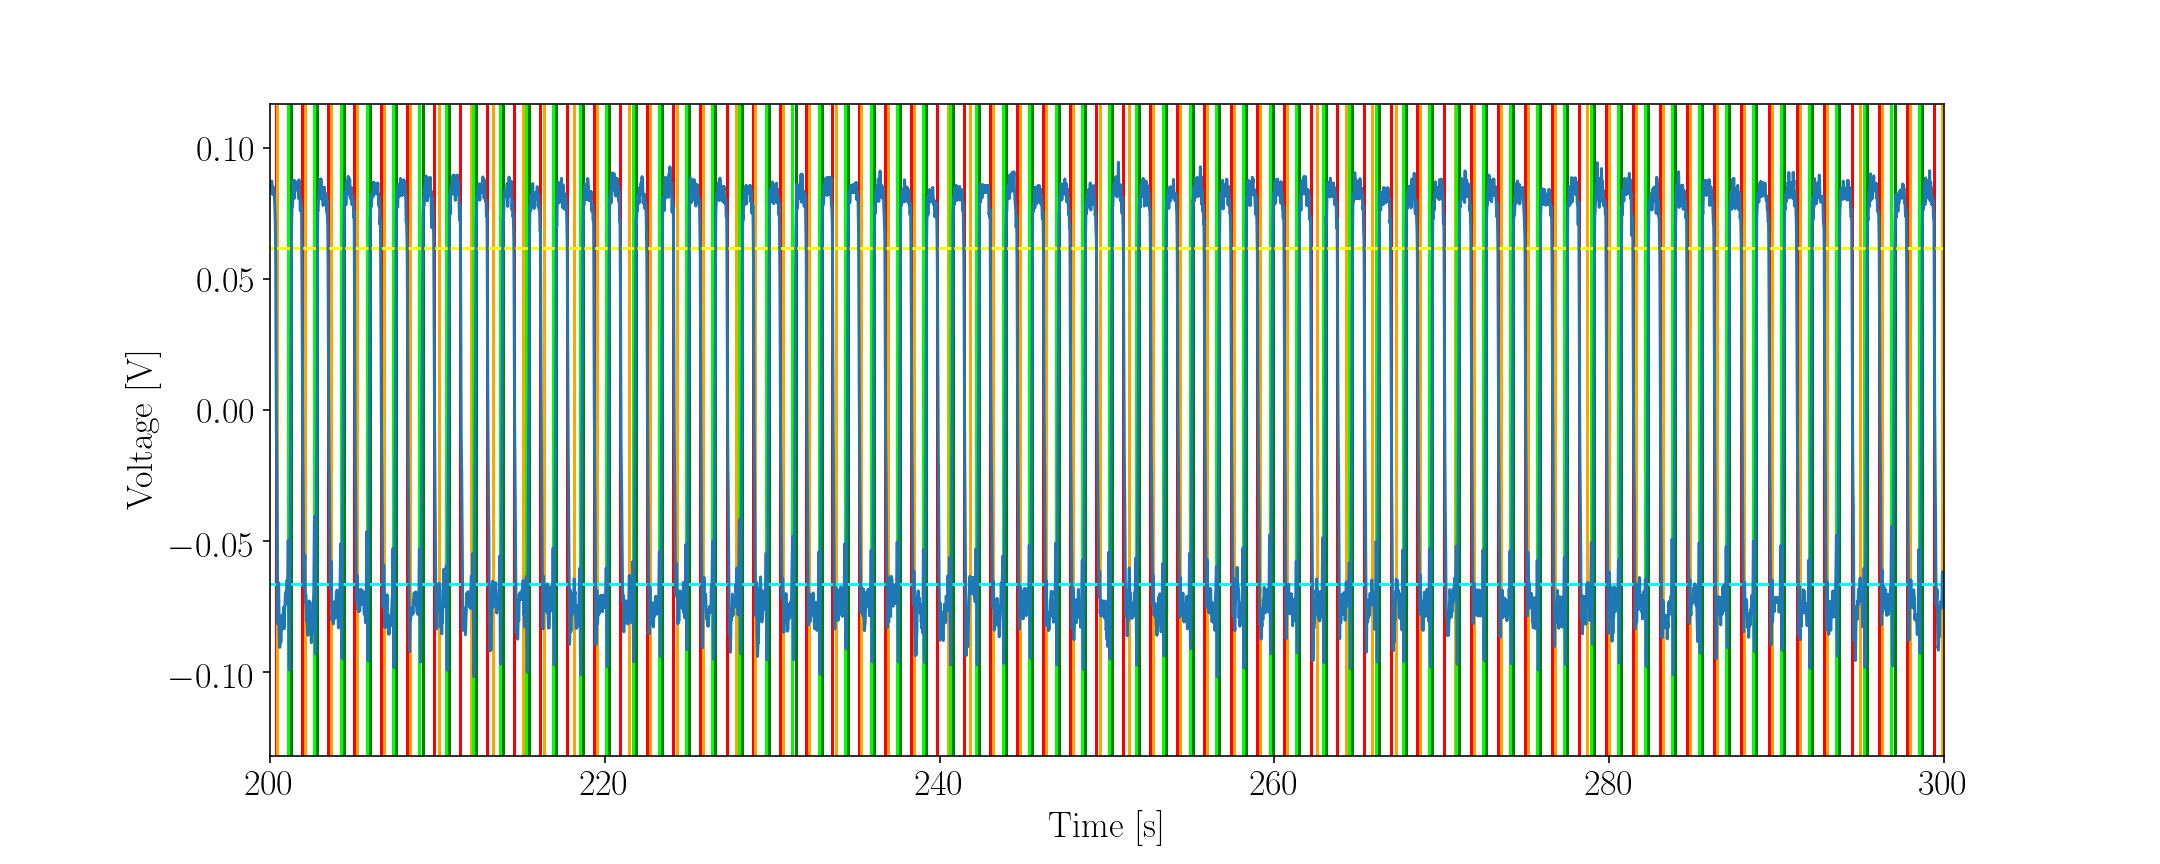

<IPython.core.display.Javascript object>


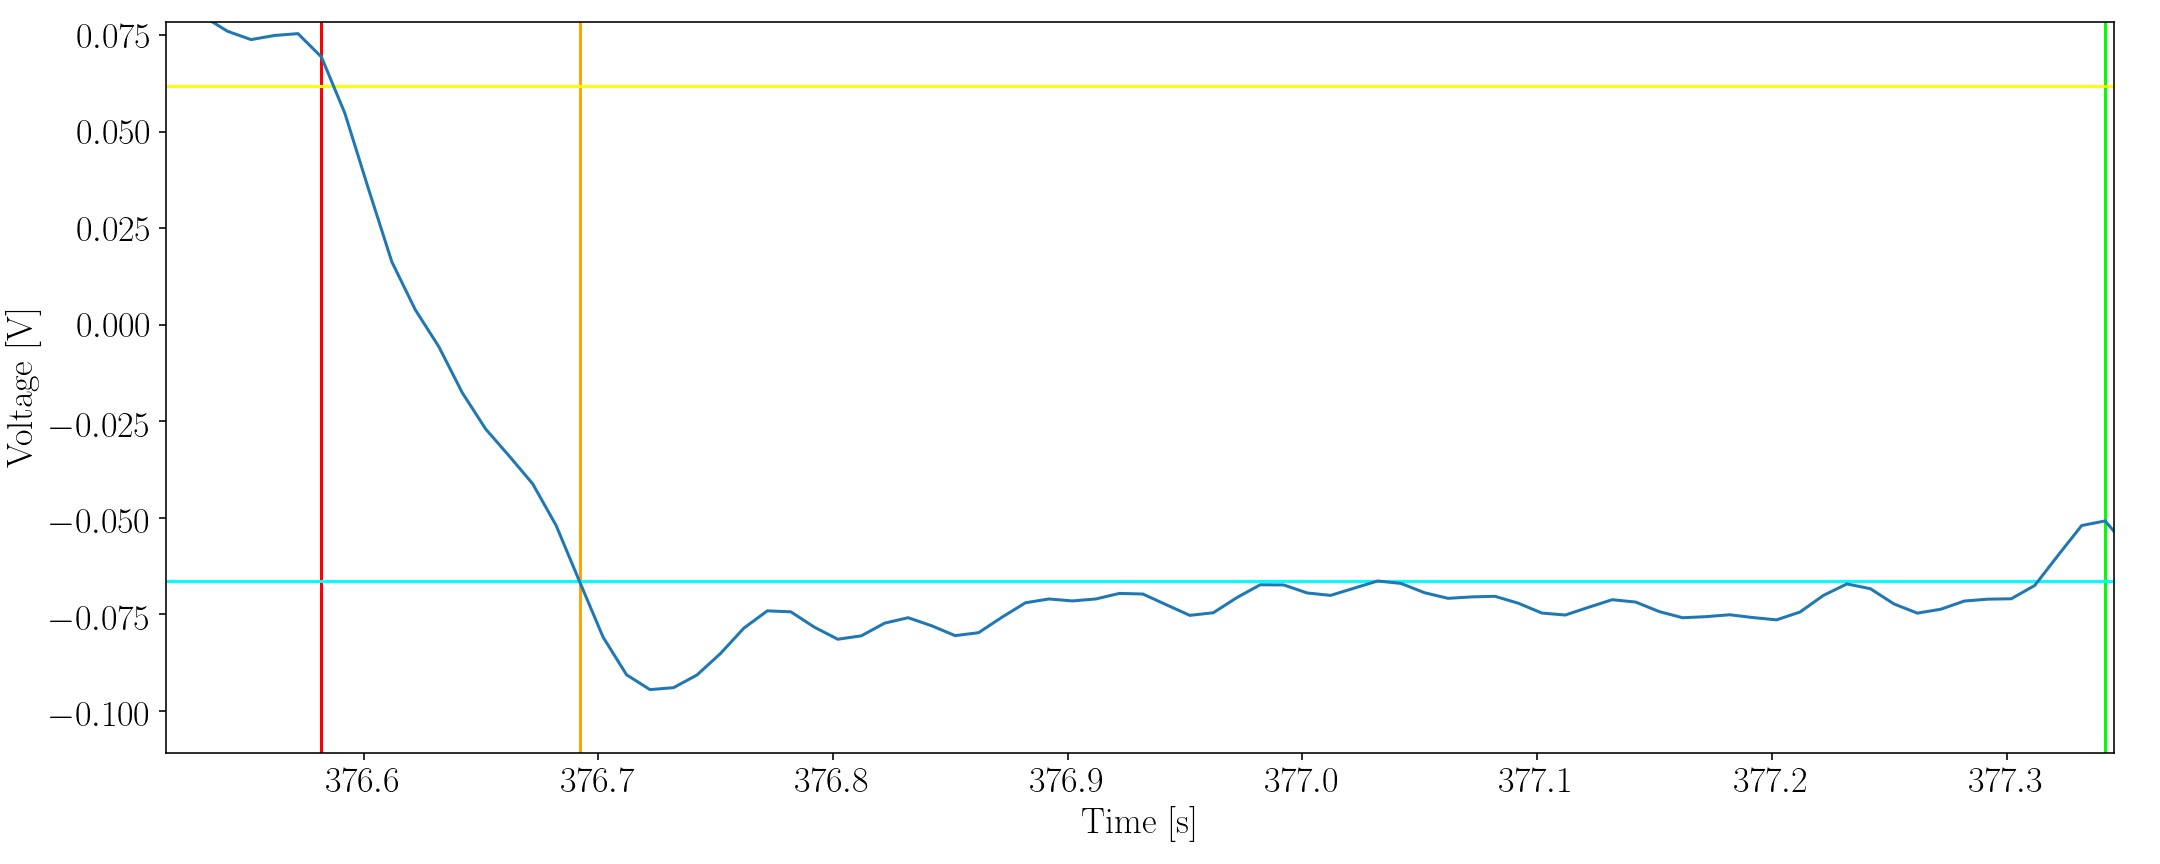

In [46]:
#****************************************
xrange = 100 # single plot x range [s]
#****************************************
reload(ddt)
%matplotlib notebook
%matplotlib notebook

returns = ddt.drop_det_new(t, sig1_r, thr_low_1, thr_high_1, backward_skip=1, forward_skip=1, return_indexes=True,
                       xrange=xrange, plot_switch=True, debug=False, xlabel="Time [s]", ylabel="Voltage [V]")

narrow_start_1, narrow_end_1, wide_start_1, wide_end_1 = returns
#function modified to give output arrays in index form, not in seconds.

drop_edges_1 = np.array(list(zip(wide_start_1, narrow_start_1, narrow_end_1, wide_end_1)))


#### Manually correct the position of the edges

<IPython.core.display.Javascript object>


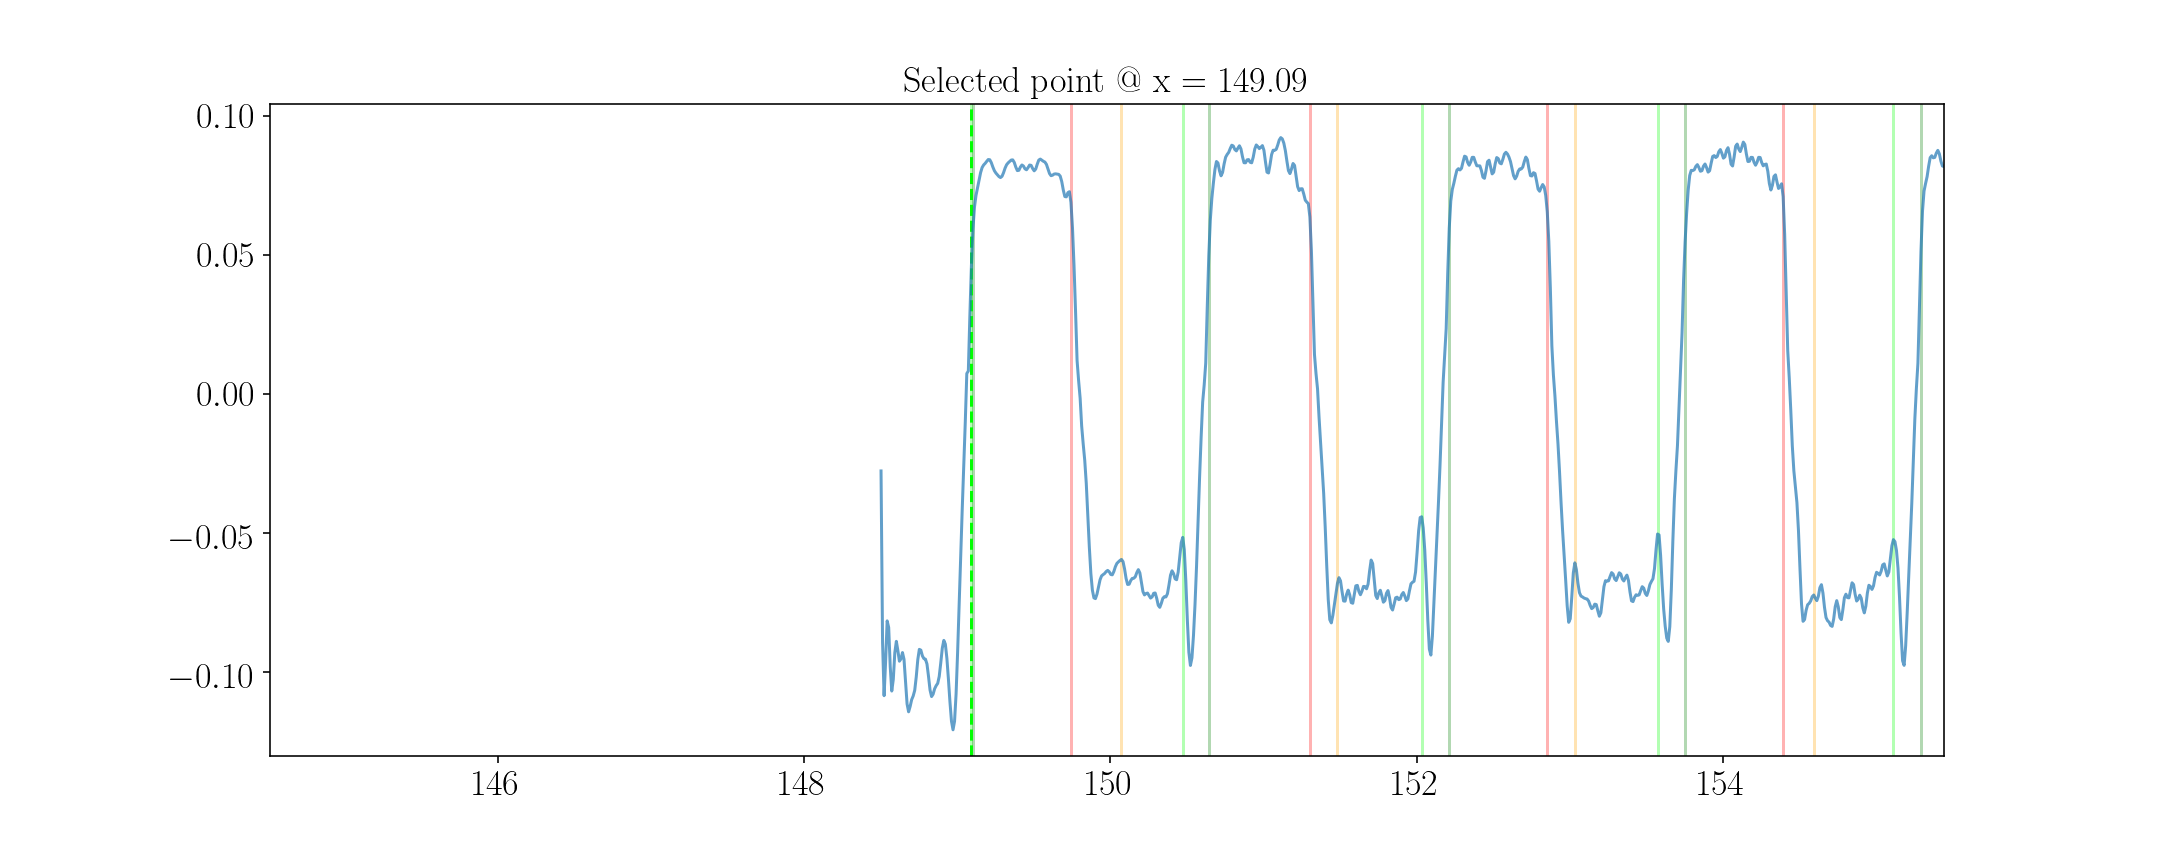

In [15]:
dec1 = ddt.DropEdgeCorrector(drop_edges_1)
dec1(t,sig1_r, figsize=(15,6))

In [ ]:
drop_edges_1 = dec1.drop_edges

wide_start_1, narrow_start_1, narrow_end_1, wide_end_1 = drop_edges_1.T

### Signal 2

In [77]:
sig2_r[np.where(t<162)]=-0.2

151 151 151 151
155.57199999999358  cannot properly find wide start: using derivative
161.1719999999885  missed previous wide end: adjusting with derivative
161.1719999999885  WRONG WIDE DROP DETECTION
168.8419999999815  missed previous wide end: adjusting with derivative
171.9219999999787  missed previous wide end: adjusting with derivative
175.1119999999758  missed previous wide end: adjusting with derivative
178.44199999997278  missed previous wide end: adjusting with derivative
188.1919999999639  missed previous wide end: adjusting with derivative
189.79199999996246  missed previous wide end: adjusting with derivative
191.401999999961  missed previous wide end: adjusting with derivative
197.75199999995522  missed previous wide end: adjusting with derivative
202.48199999995092  missed previous wide end: adjusting with derivative
204.08199999994946  missed previous wide end: adjusting with derivative
205.66199999994802  missed previous wide end: adjusting with derivative
207.24199999

<IPython.core.display.Javascript object>


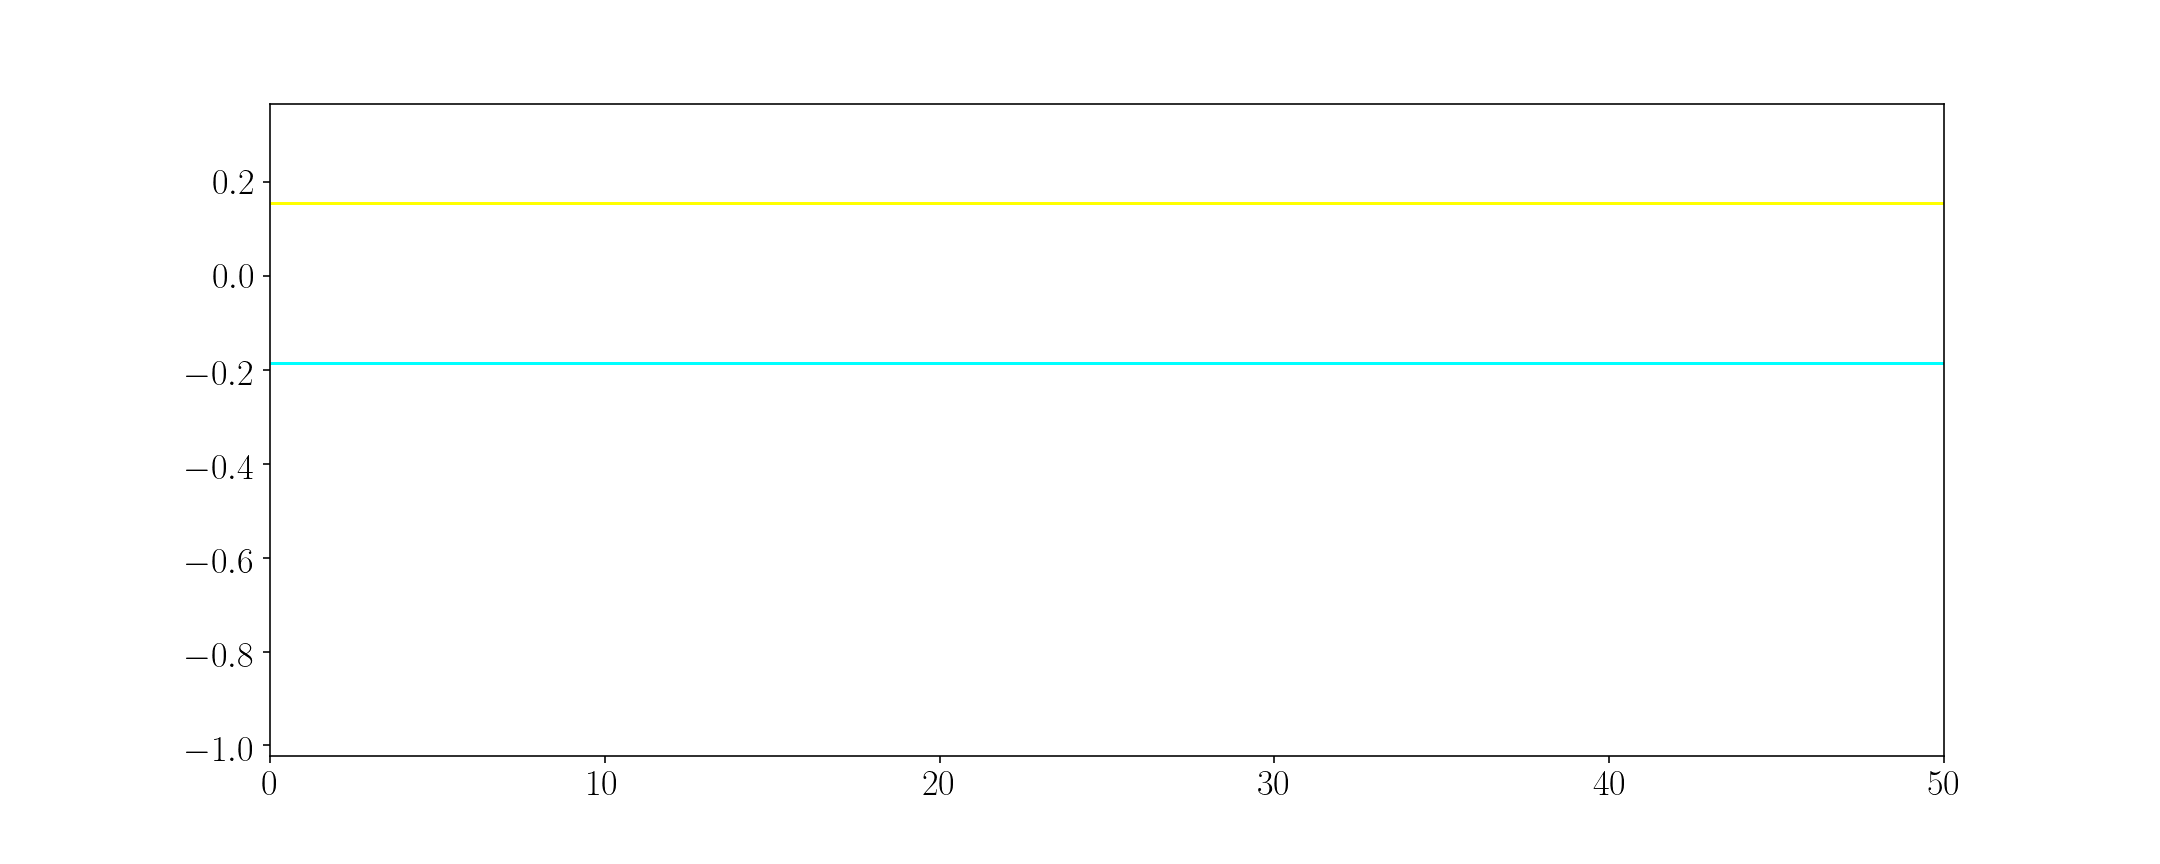

<IPython.core.display.Javascript object>


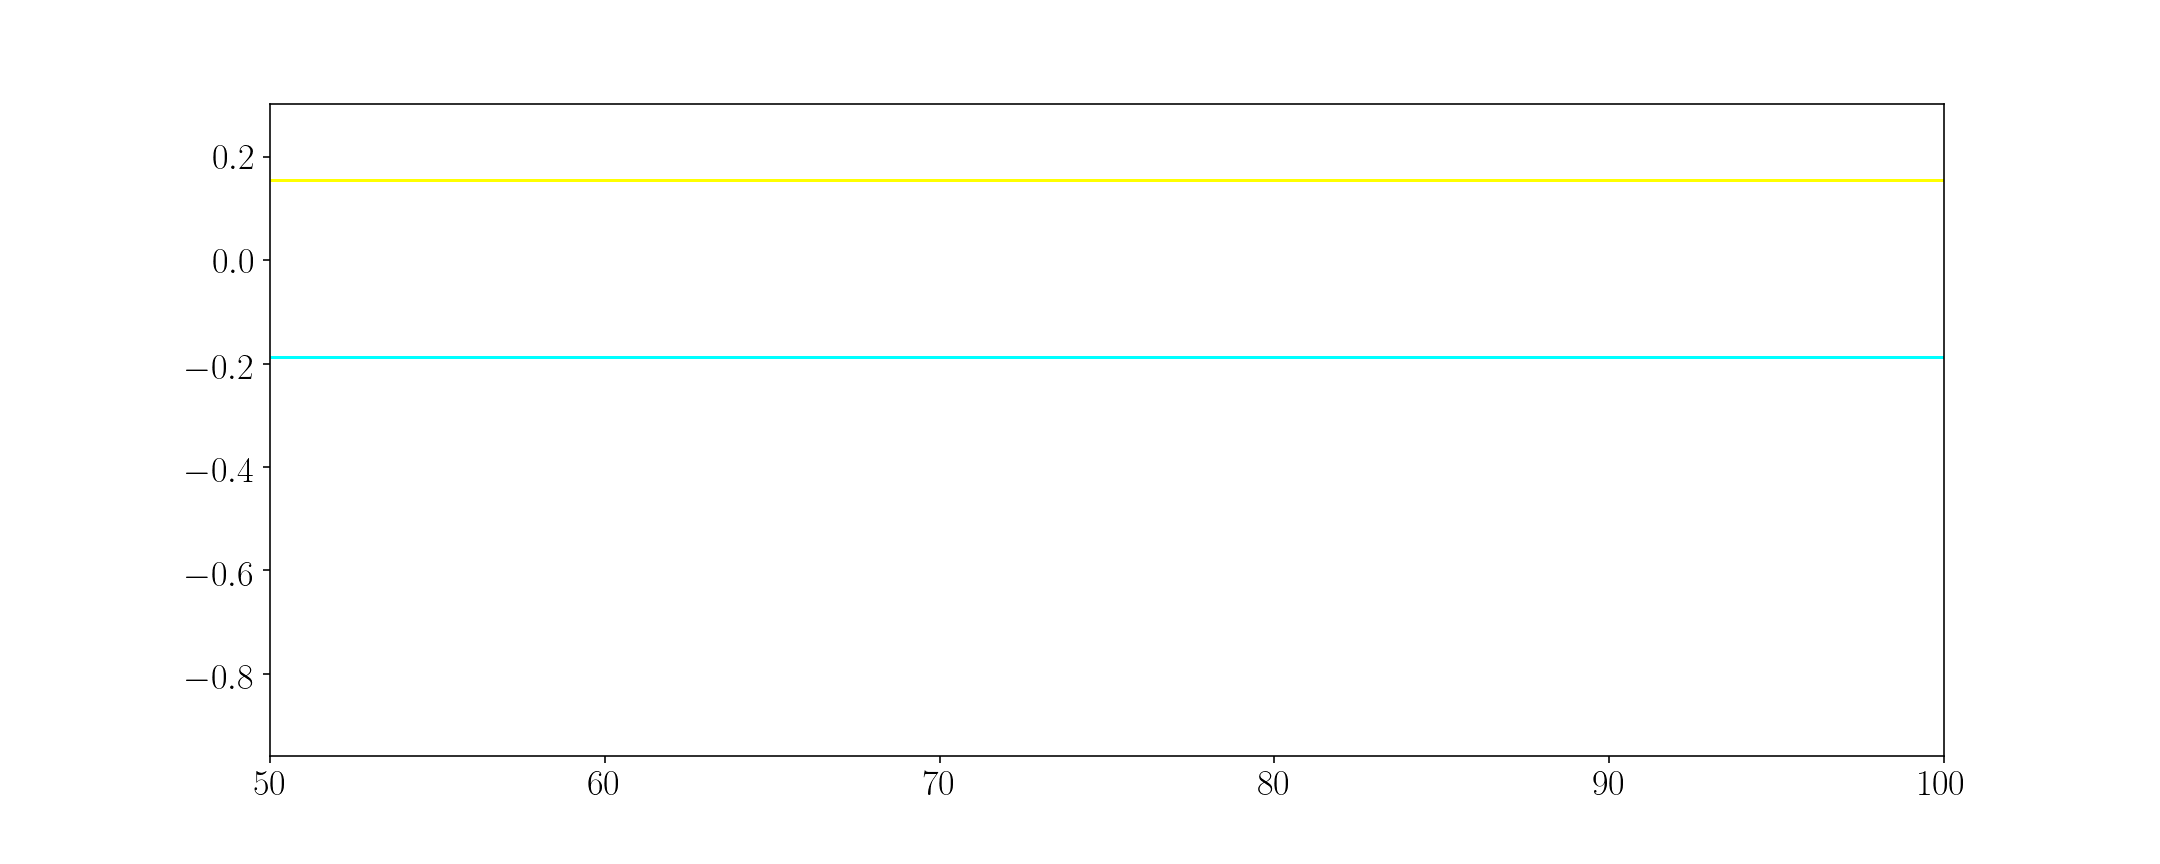

<IPython.core.display.Javascript object>


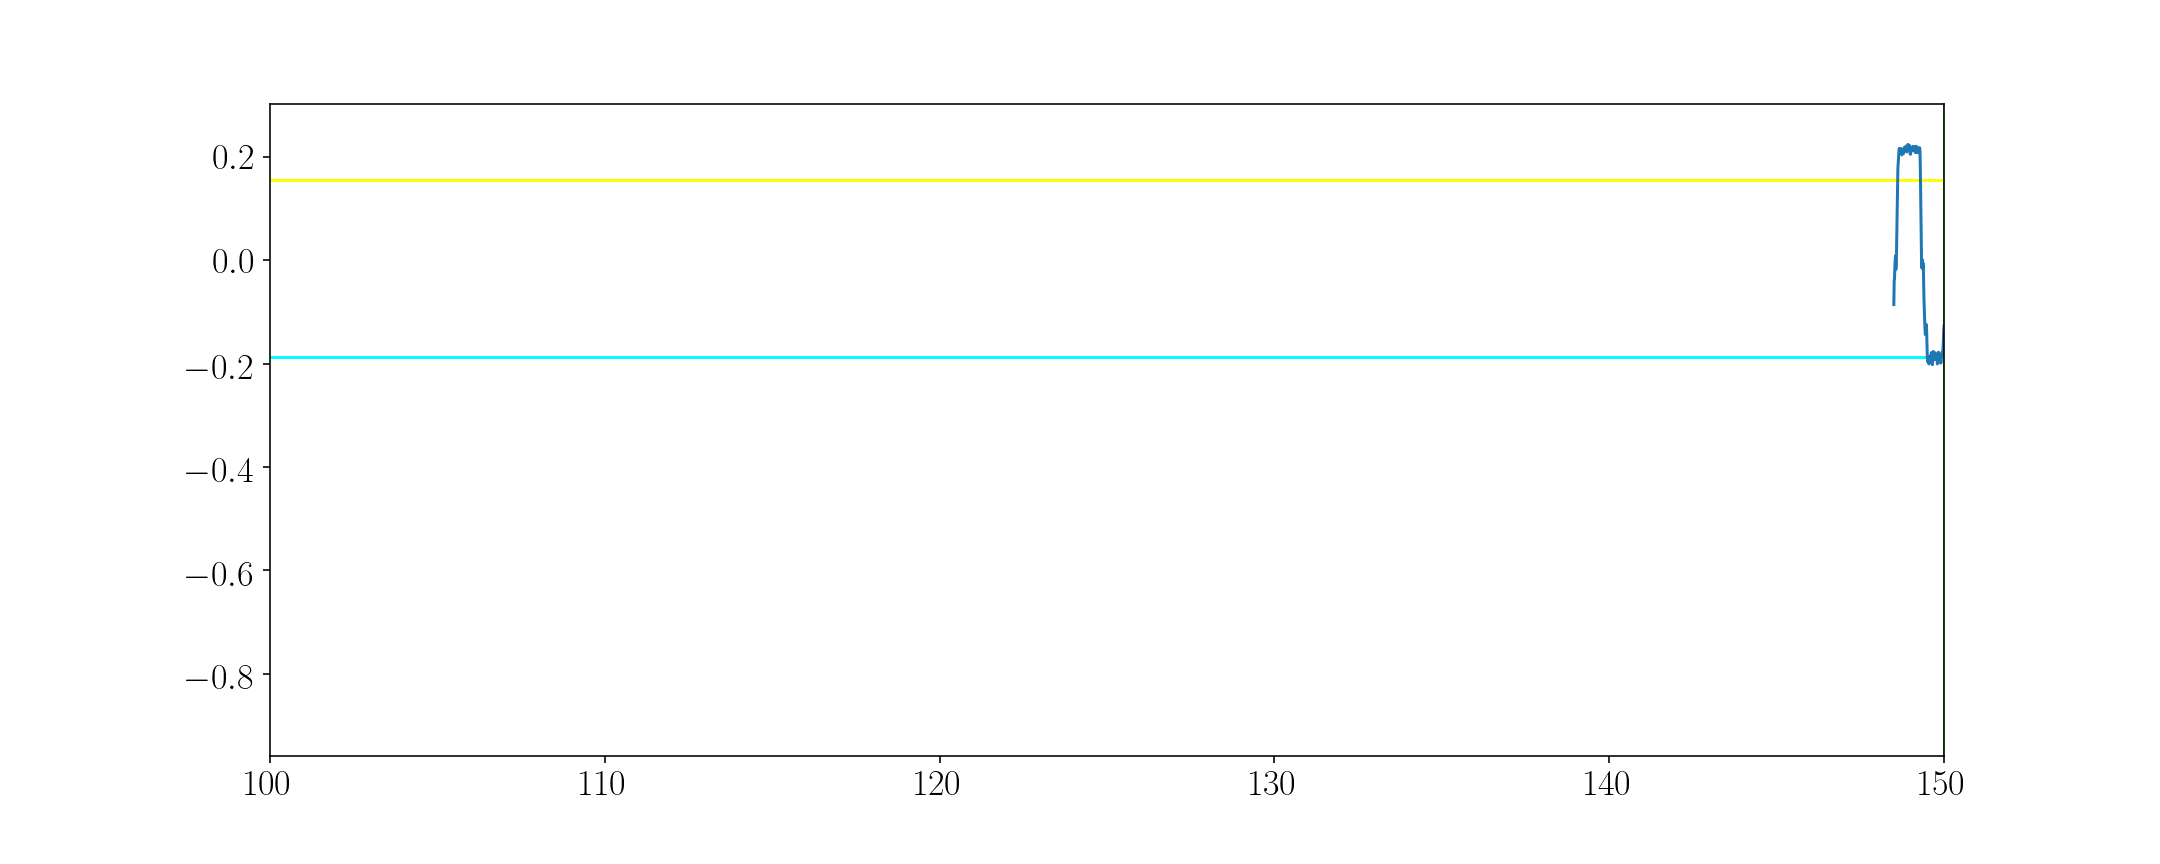

<IPython.core.display.Javascript object>


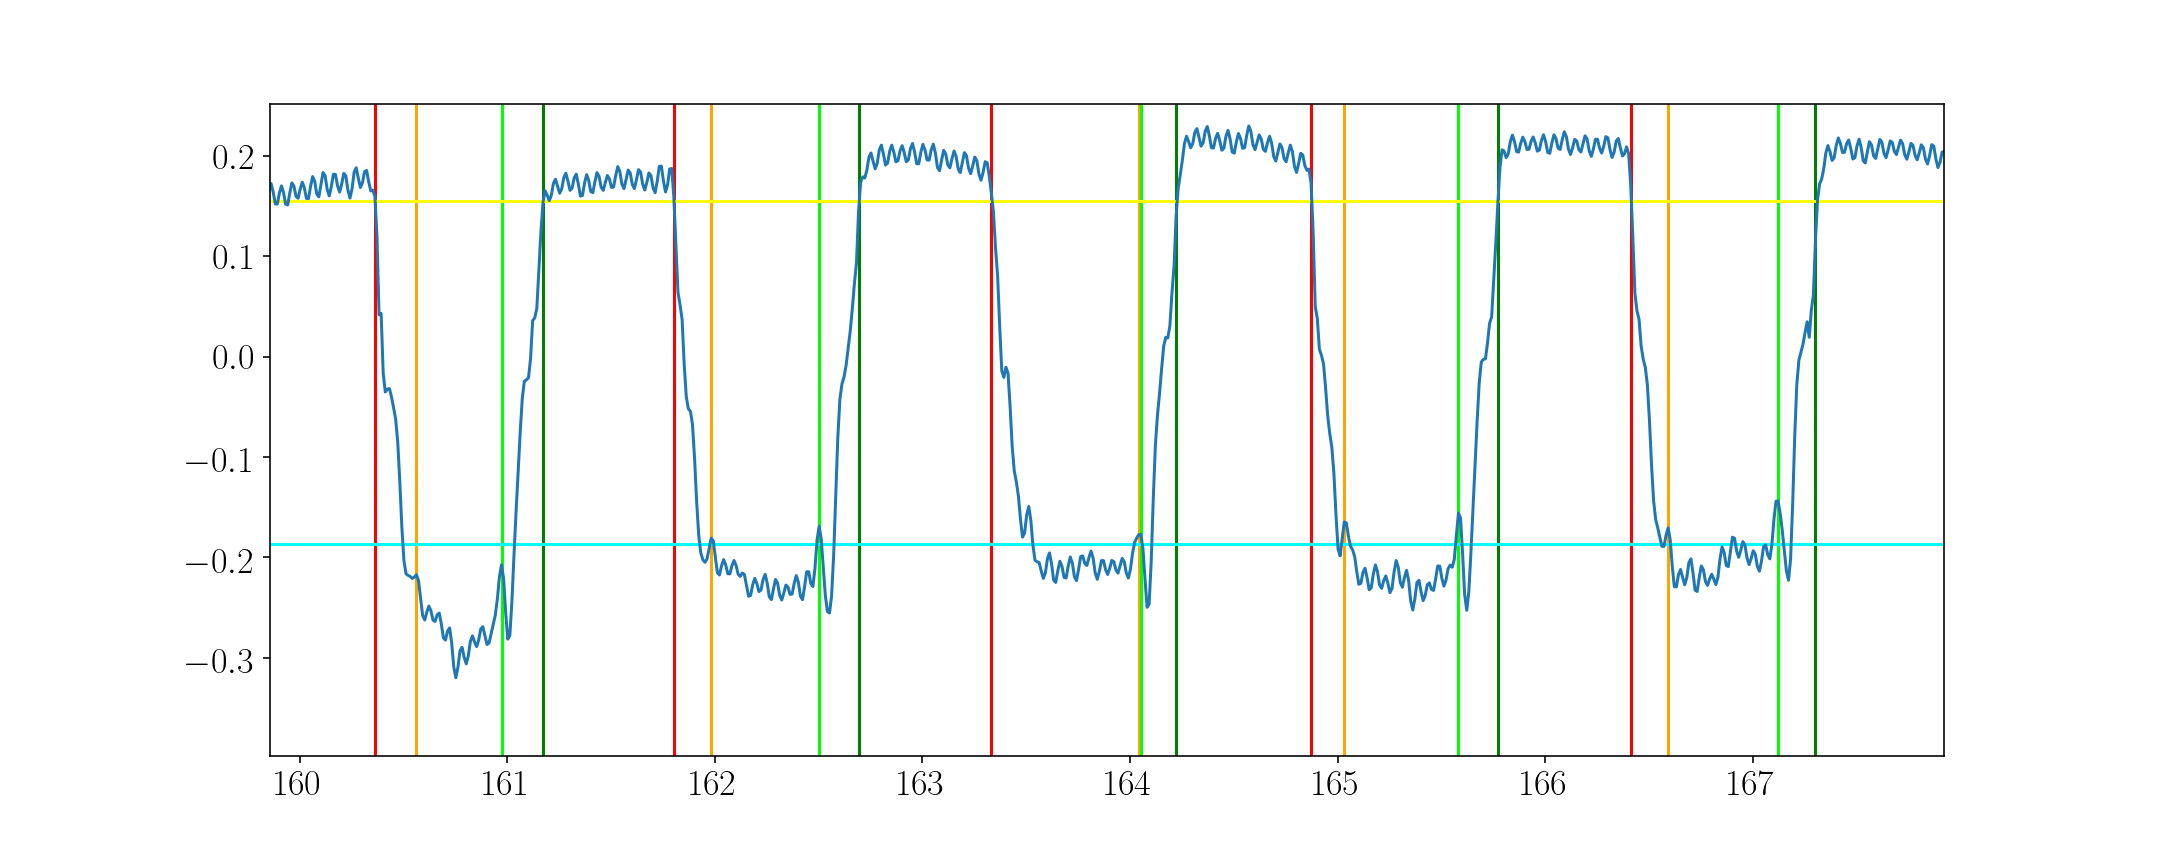

<IPython.core.display.Javascript object>


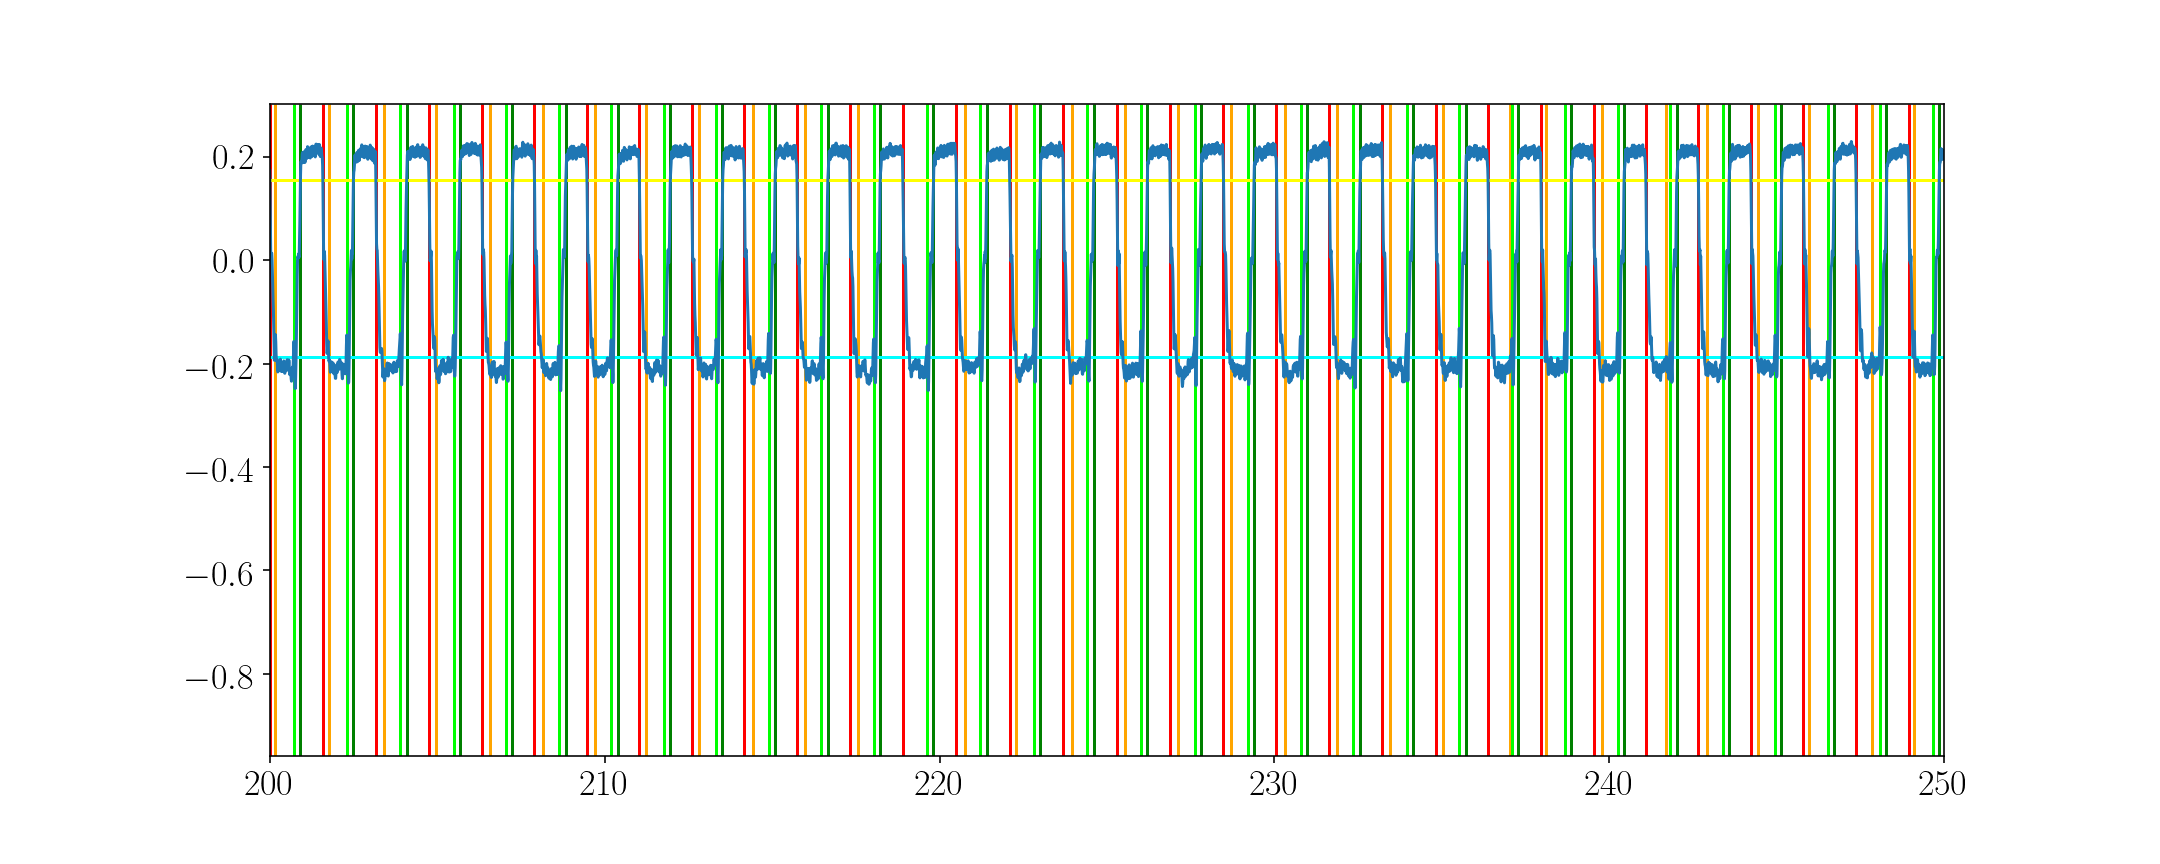

<IPython.core.display.Javascript object>


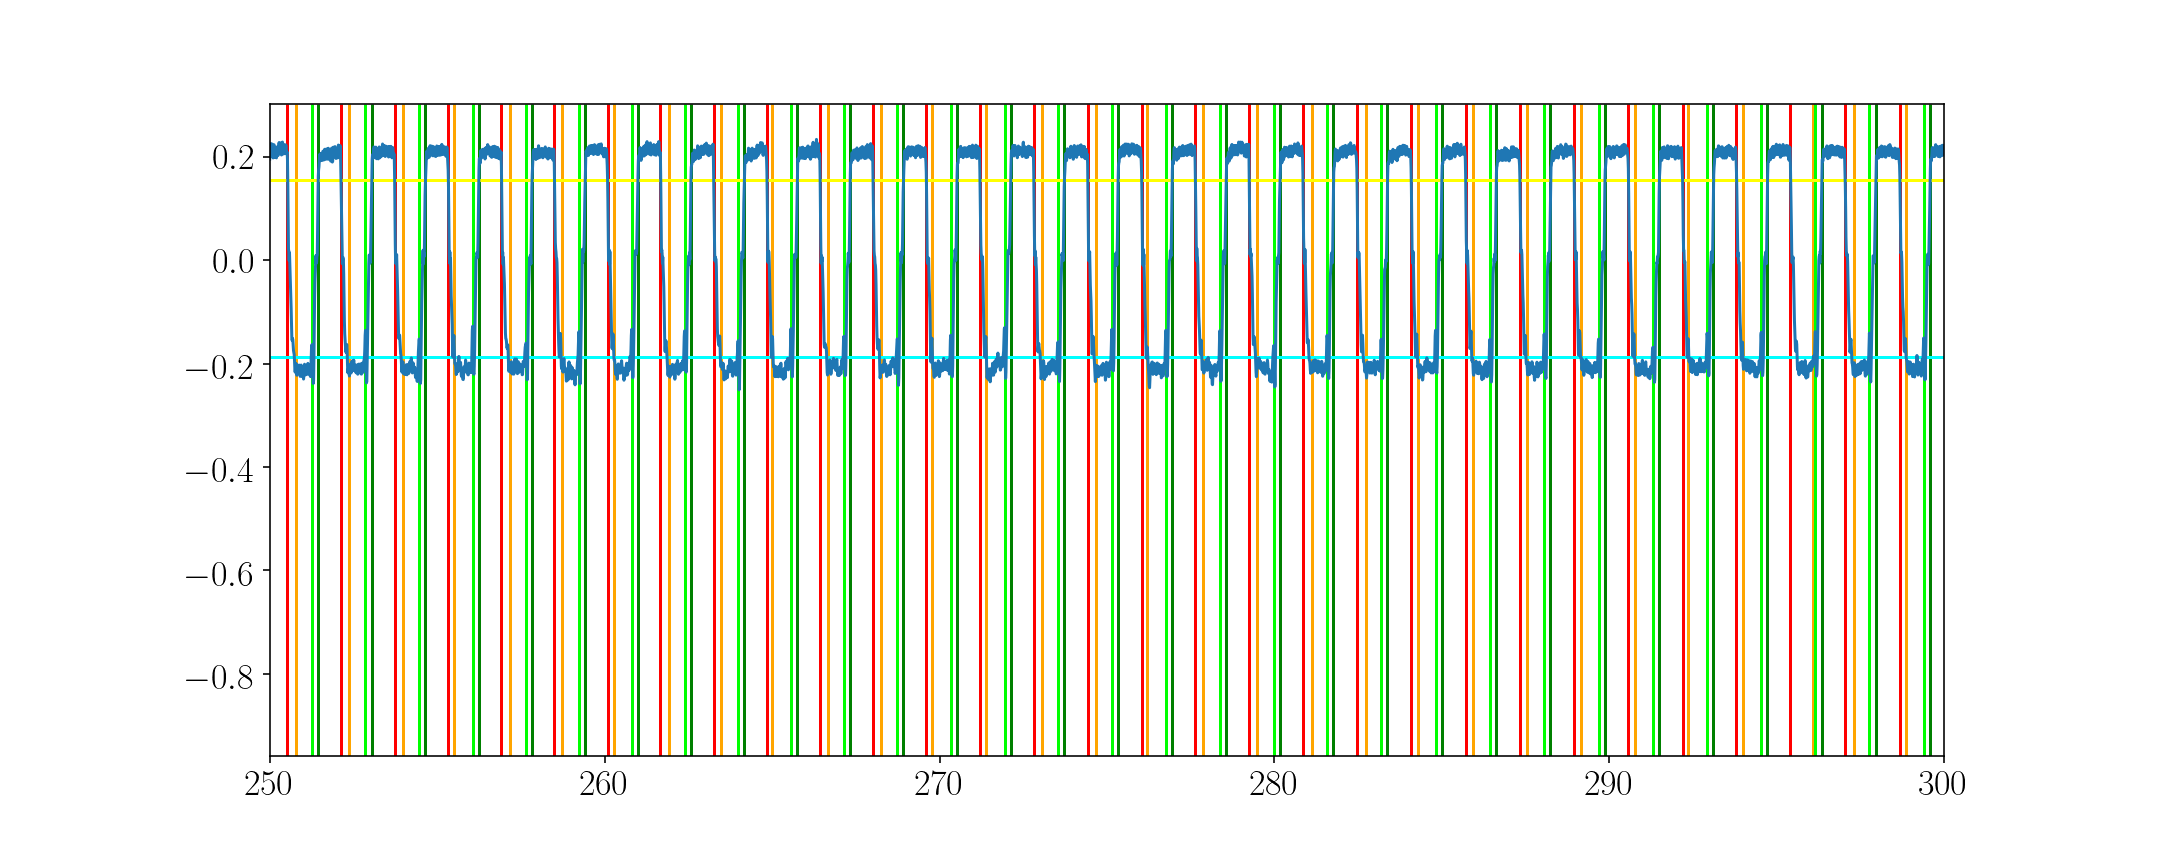

<IPython.core.display.Javascript object>


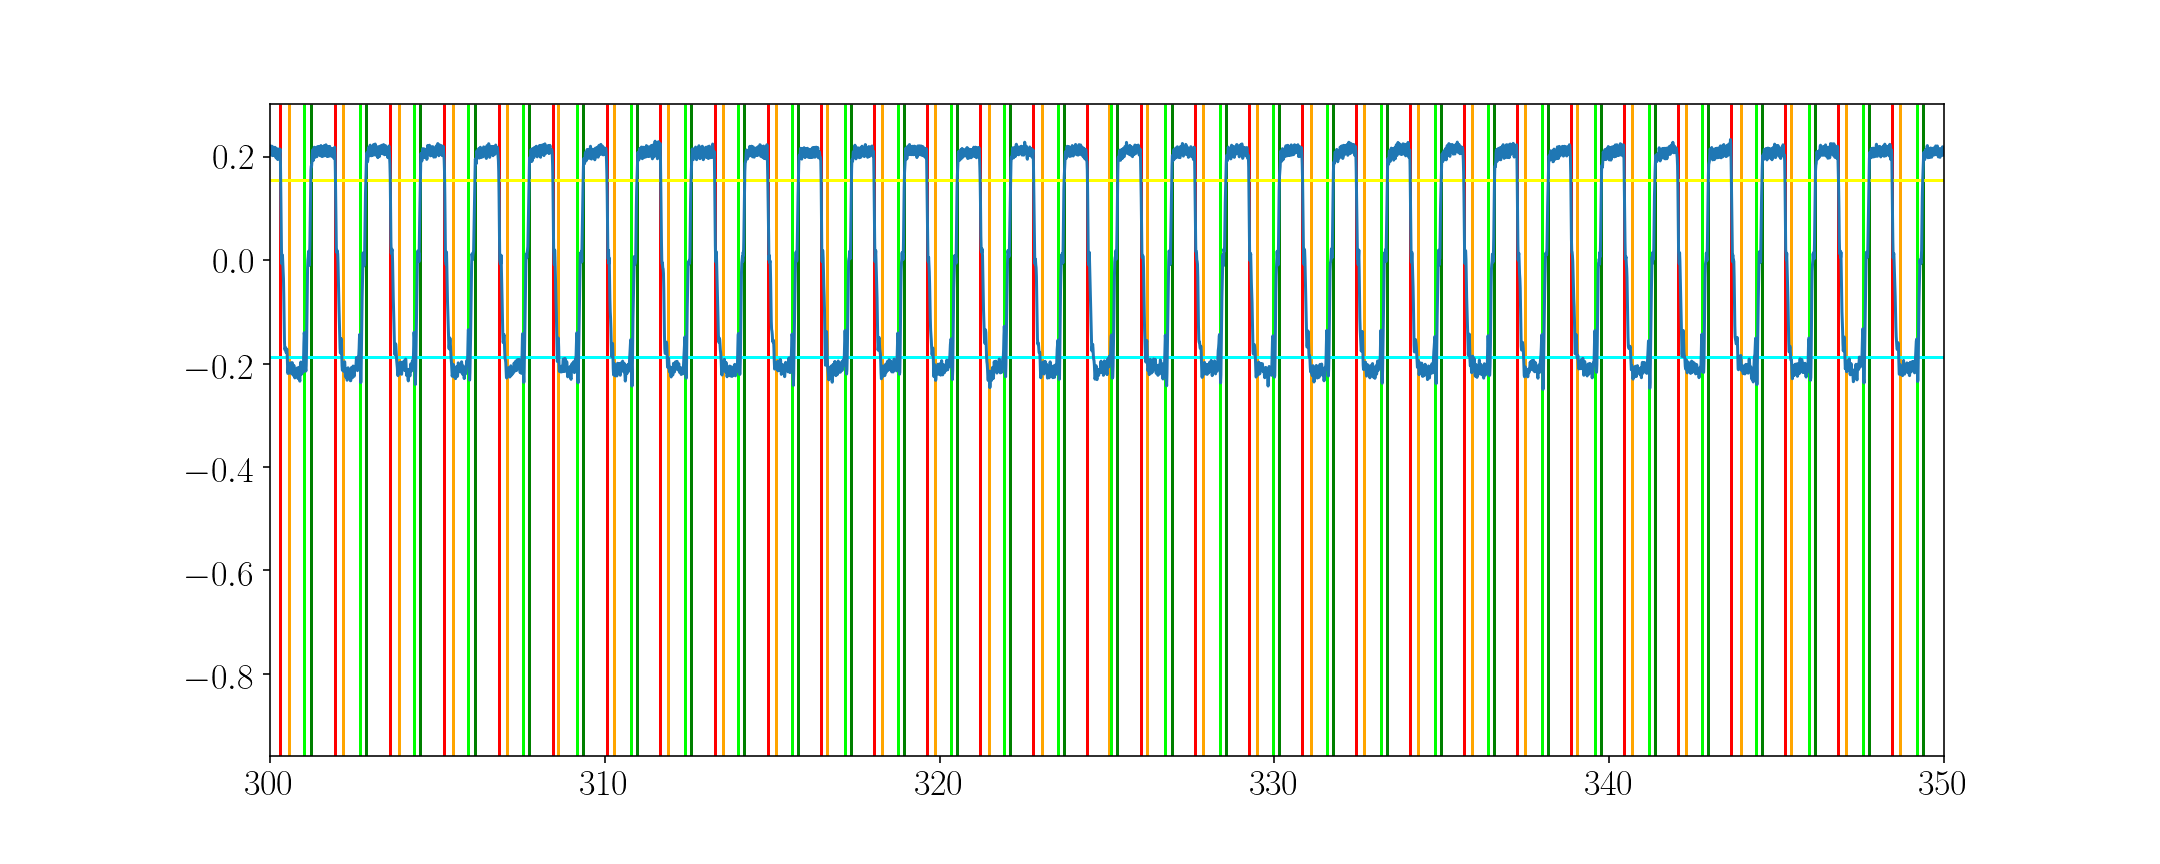

<IPython.core.display.Javascript object>


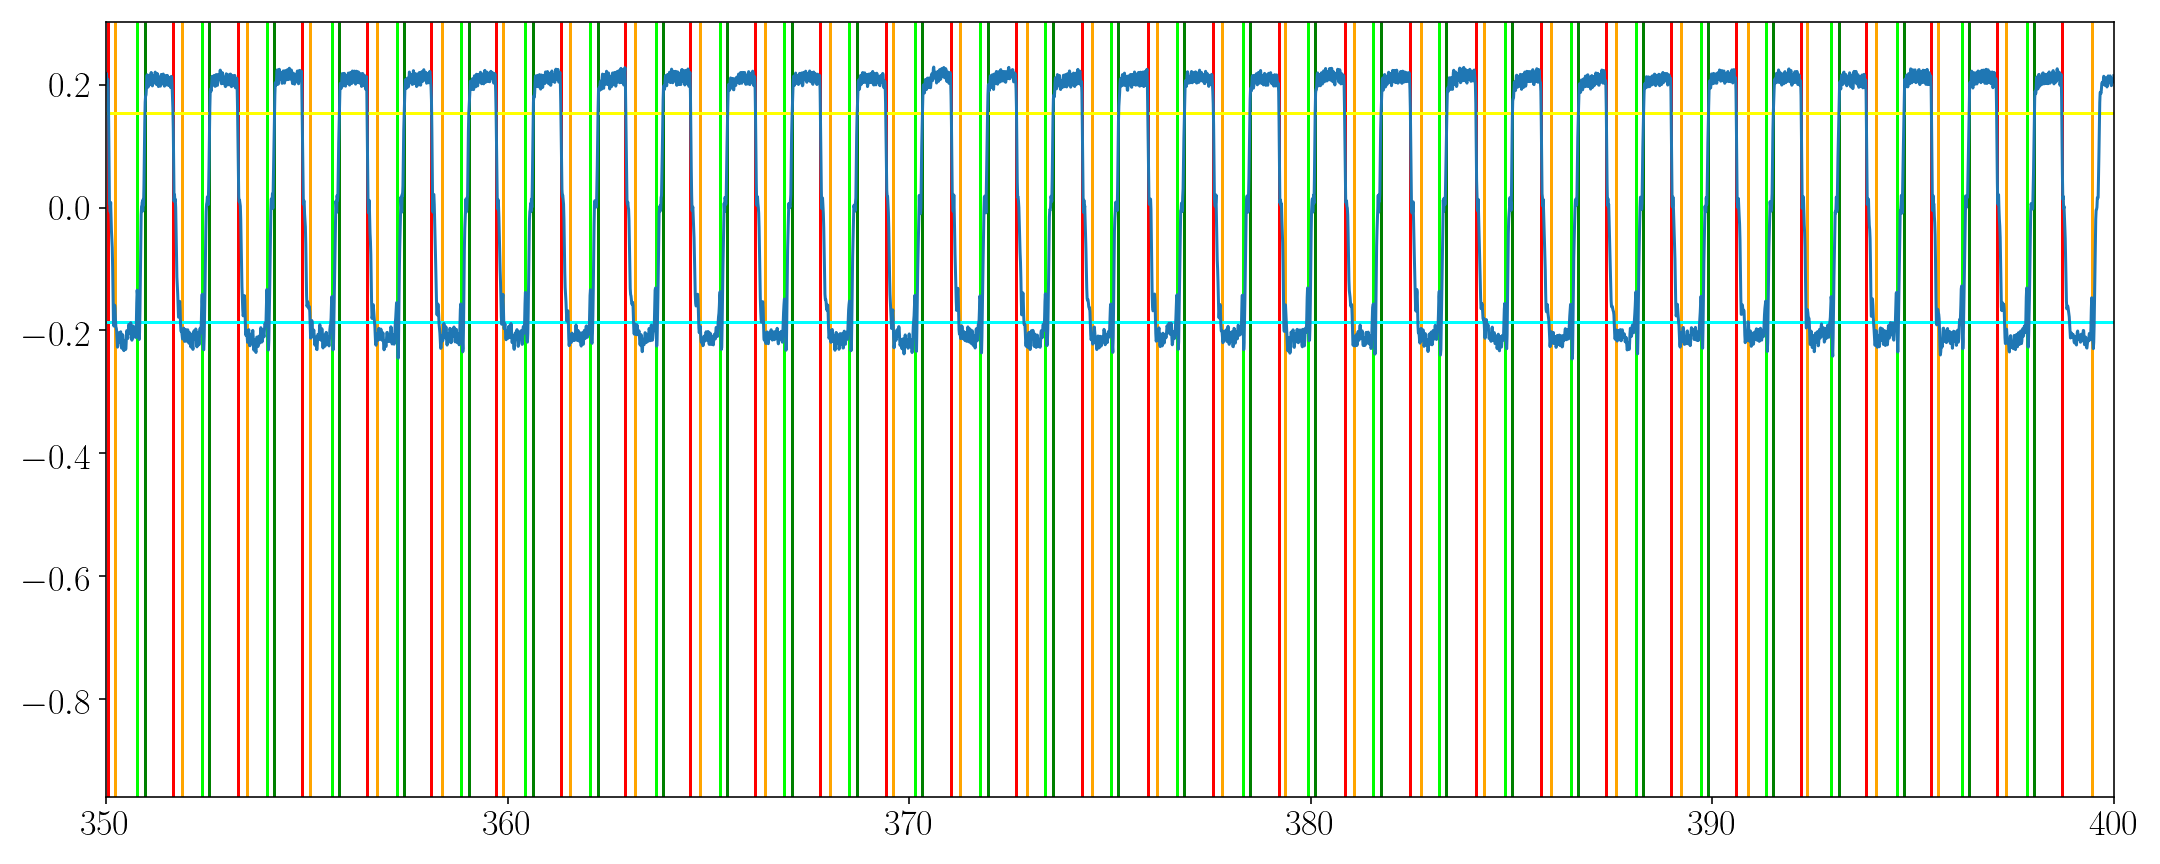

In [48]:
#****************************************
xrange = 50 # single plot x range [s]
#****************************************

%matplotlib notebook
returns = ddt.drop_det_new(t, sig2_r, thr_low_2, thr_high_2, backward_skip=1, forward_skip=1, return_indexes=True,
                       xrange=xrange, plot_switch=True)

narrow_start_2, narrow_end_2, wide_start_2, wide_end_2 = returns
#function modified to give output arrays in index form, not in seconds.

drop_edges_2 = np.array(list(zip(wide_start_2, narrow_start_2, narrow_end_2, wide_end_2)))


In [ ]:
help(ddt.DropEdgeCorrector)

<IPython.core.display.Javascript object>


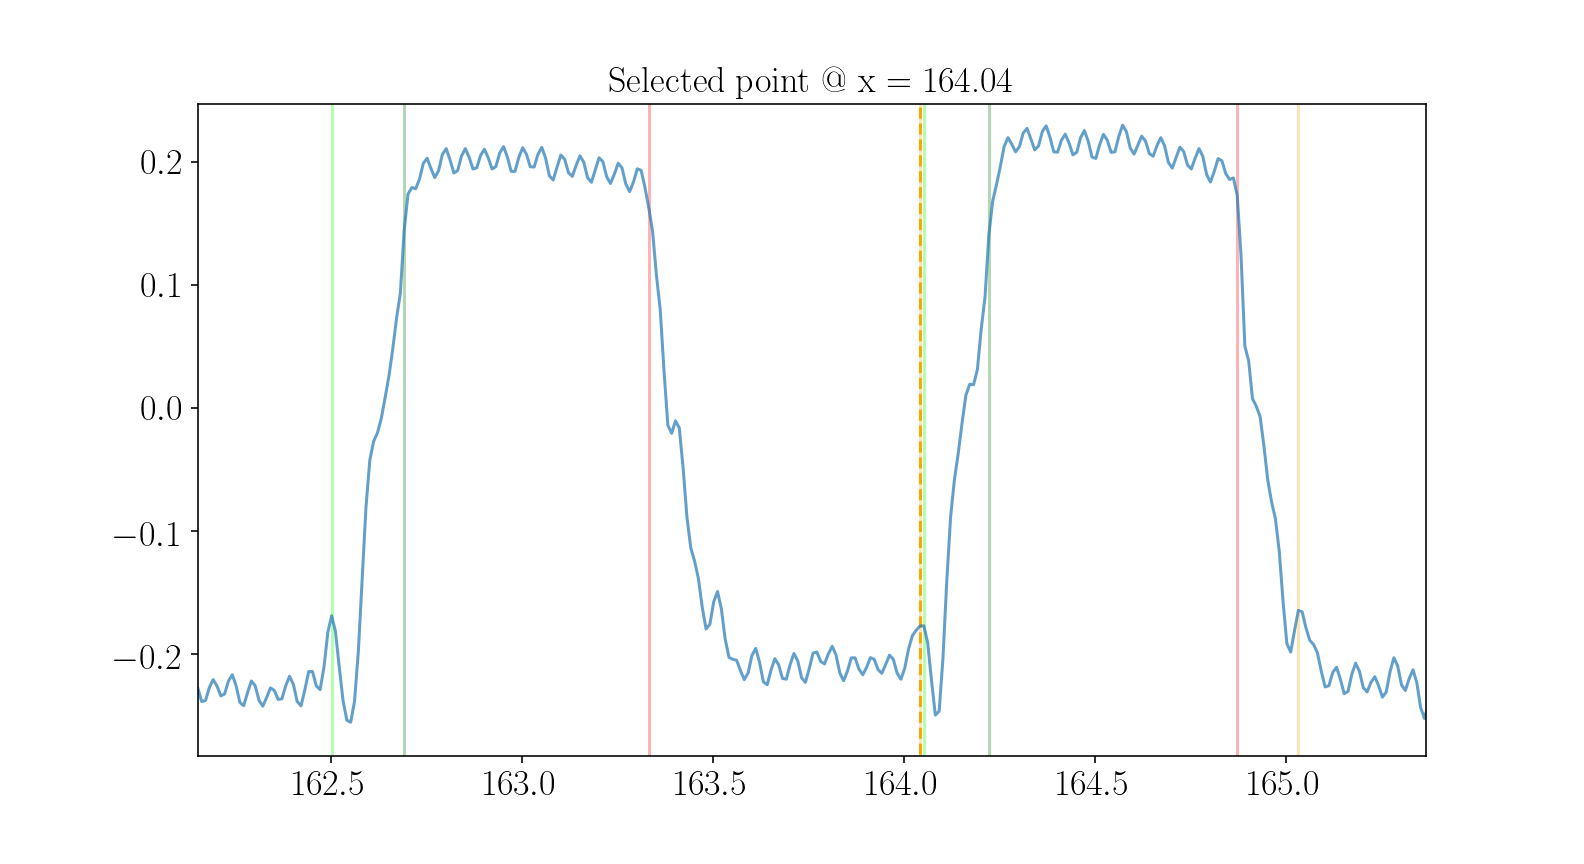

In [49]:
dec2 = ddt.DropEdgeCorrector(drop_edges_2)
dec2(t,sig2_r, figsize=(11,6))

In [ ]:
drop_edges_2 = dec2.drop_edges

wide_start_2, narrow_start_2, narrow_end_2, wide_end_2 = drop_edges_2.T

## Add errors

<IPython.core.display.Javascript object>


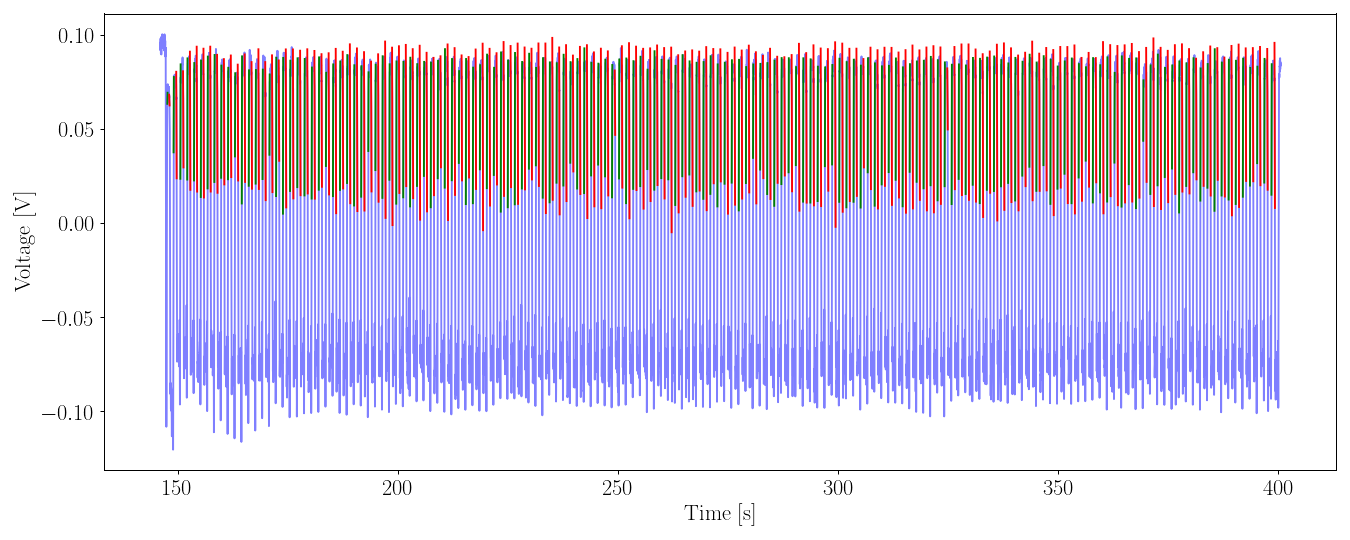

In [48]:
%matplotlib notebook
%matplotlib notebook
slope_start_1, slope_end_1=ddt.slopes(t,sig1_r, narrow_start_1, narrow_end_1, start_range=3, end_range = 5, xlabel="Time [s]", ylabel="Voltage [V]")

<IPython.core.display.Javascript object>


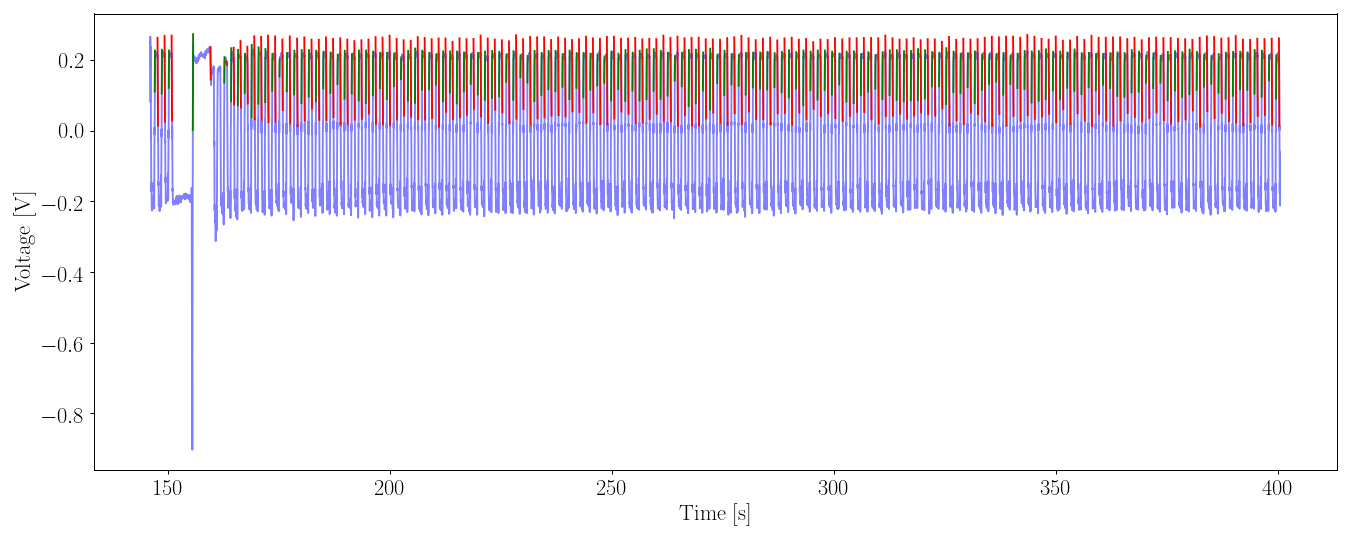

In [49]:
slope_start_2, slope_end_2=ddt.slopes(t,sig2_r, narrow_start_2, narrow_end_2, start_range=3, end_range = 5, xlabel="Time [s]", ylabel="Voltage [V]")

In [50]:
#slope errors for narrow_start and narrow_end
v_err_1 = sigma_high_1
err_slope_start_1 = v_err_1/slope_start_1
err_slope_end_1 = -v_err_1/slope_end_1

v_err_2 = sigma_high_2
err_slope_start_2 = v_err_2/slope_start_2
err_slope_end_2 = -v_err_2/slope_end_2


In [51]:
def res_error(time):
    a = t_raw[np.where(t_raw >= time)]
    if len(a)>1:
        return (a[1] - a[0])/np.sqrt(12)
    else: return 0
#     return a[1] - a[0]

### Make ufloats

In [52]:
#error resolution + error slope (seconds)
err_n_start_1=[]
err_n_end_1=[]
err_w_start_1=[]
err_w_end_1=[]
err_n_start_2=[]
err_n_end_2=[]
err_w_start_2=[]
err_w_end_2=[]

drop_edges_1 = [err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1]
drop_edges_2 = [err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2]

for drop_idx in range(len(narrow_start_1)):
    ens1 = (np.sqrt(res_error(t[narrow_start_1[drop_idx]])**2 + err_slope_start_1[drop_idx]**2))
    ene1 = (np.sqrt(res_error(t[narrow_end_1[drop_idx]])**2 + err_slope_end_1[drop_idx]**2))
    ews1 = (res_error(t[wide_start_1[drop_idx]]))
    ewe1 = (res_error(t[wide_end_1[drop_idx]]))
    
    err_n_start_1.append(unc.ufloat(t[narrow_start_1[drop_idx]],ens1))
    err_n_end_1.append(unc.ufloat(t[narrow_end_1[drop_idx]],ene1))
    err_w_start_1.append(unc.ufloat(t[wide_start_1[drop_idx]],ews1))
    err_w_end_1.append(unc.ufloat(t[wide_end_1[drop_idx]],ewe1))

for drop_idx in range(len(narrow_start_2)):
    ens2 = (np.sqrt(res_error(t[narrow_start_2[drop_idx]])**2 + err_slope_start_2[drop_idx]**2))
    ene2 = (np.sqrt(res_error(t[narrow_end_2[drop_idx]])**2 + err_slope_end_2[drop_idx]**2))
    ews2 = (res_error(t[wide_start_2[drop_idx]]))
    ewe2 = (res_error(t[wide_end_2[drop_idx]]))
    
    err_n_start_2.append(unc.ufloat(t[narrow_start_2[drop_idx]],ens2))
    err_n_end_2.append(unc.ufloat(t[narrow_end_2[drop_idx]],ene2))
    err_w_start_2.append(unc.ufloat(t[wide_start_2[drop_idx]],ews2))
    err_w_end_2.append(unc.ufloat(t[wide_end_2[drop_idx]],ewe2))
    

drop_edges_1 = [np.array(e) for e in drop_edges_1]
drop_edges_2 = [np.array(e) for e in drop_edges_2]

err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1 = drop_edges_1
err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2 = drop_edges_2

to_adjust = True

## Delay between detectors

In [ ]:
# spannometric estimation of the time interval between the drops, knowing the pumps fluxes and capillary size

#********************************************************
radius  = 0.3  # capillary radius [mm]
sep     = 50   # spearation between the two sensors [mm]
flux_ol = 3    # oil flux   [uL/min] = [mm3/min]
flux_aq = 7    # water flux [uL/min] = [mm3/min]
#********************************************************

A  = np.pi*0.25*radius**2       # capillary area [mm2]
v  = (flux_ol + flux_aq)/A/60   # drops speed [mm/s]
dt = sep/v                      # time interval between two following drops [s]

print('v  = ', v,'\t[mm/s] \ndt = ', dt, '\t[s]')

In [ ]:
#this function calculates delay between sig1 and sig2 by spectra smoothing (delay_gauss) 
#and by simple spectra subtraction (delay_spectra)
    
def delay(sigma, delta, delta_delay, step_delay, start_time, stop_time, step_time, vec1, vec2, signal1, signal2,
          min_cut_idx=0, max_cut_idx=5000):   
    
    
    # Gaussian formula ---------------------------------------

    q = np.sqrt(2*np.pi)
    def gaus(x, mu, sigma):
        return np.exp(-(x - mu)**2/(2*sigma**2))/(sigma*q)

    
    # Gaussian smoothing functions ---------------------------

    # Signal 1
    @np.vectorize
    def sig1_smooth(t, sigma, delta):
        s = 0.
        for t_s in vec1:
            if (t - t_s)**2 < (delta*sigma)**2:
                s += gaus(t,t_s,sigma)
            if t_s - t > (delta+1)*sigma:
                break
        return s
    
    # Signal 2
    @np.vectorize
    def sig2_smooth(t, sigma, delta):
        s = 0.
        for t_s in vec2:
            if (t - t_s)**2 < (delta*sigma)**2:
                s += gaus(t,t_s,sigma)
            if t_s - t > (delta+1)*sigma:
                break
        return s


    # Delay computing ::::::::::::::::::::::::::::::::::::::::::::
    
    start_delay = dt - delta_delay                                # initial evaluated delay [s]
    stop_delay  = dt + delta_delay                                # final evaluated delay [s]
    time_delays = np.arange(start_delay, stop_delay, step_delay)  # vector of evaluated delays [s]
    ts          = np.arange(start_time,  stop_time,  step_time)   # vector of scanned times [s]
    msqs        = []                                              # stdev between sig.1 and sig.2 delayed 

    
    # Computing delay_gauss --------------------------------------
    
    for time_delay in tqdm(time_delays):

        sig1_t = sig1_smooth(ts, sigma, delta)
        sig2_t = sig2_smooth(ts + time_delay, sigma, delta)
        msqs.append(np.mean((sig2_t - sig1_t)**2))

    msqs=np.array(msqs)
    delay_gauss=time_delays[msqs==min(msqs)]
    
    
    # Delay with spectra-subtraction -----------------------------
    
    delay_idxs = np.arange(int(start_delay*100), int(stop_delay*100))
    msqs1 = []

    for idx in delay_idxs:
            #sig1_cut = sig1_high[:len(sig2_high) - idx][start_time*100:stop_time*100]
            #sig2_cut = sig2_high[idx:][start_time*100:stop_time*100]
            sig1_cut = signal1[:len(signal2) - idx][min_cut_idx:max_cut_idx]
            sig2_cut = signal2[idx:][min_cut_idx:max_cut_idx]
            msqs1.append(np.mean((sig1_cut - sig2_cut)**2))
    msqs1=np.array(msqs1)
    delay_spectra=t[delay_idxs[[msqs1==min(msqs1)]]] 
   

    # Plots ------------------------------------------------------
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))    
    ax[0].set_title('Delay spectrum from gaussian broadening')
    ax[0].set_xlabel("delay [s]")
    ax[0].set_ylabel("msqs")
    ax[0].plot(time_delays,msqs)
    ax[1].set_title('Delay spectrum from signal subtraction')
    ax[1].set_xlabel("Delay [s]")
    ax[1].set_ylabel("msqs")
    ax[1].set_xlim(*ax[0].get_xlim())
    ax[1].plot(t[delay_idxs],msqs1)
    fig.tight_layout()
    
    #define the number of initial drops to be neglected in sig2 
    neglected_drops_2 = vec2[vec2<delay_spectra]
    d2 = len(neglected_drops_2)    
          
    return delay_gauss, delay_spectra, d2

In [ ]:
#*********************************************************************************************
# Signal gaussian smoothing
sigma       = 0.01   # stdev
delta       = 2      # range = delta*stdev
# Delay
delta_delay = 10      # range of evaluated delays = [dt - delta_delay ; dt + delta_delay] [s]
step_delay  = 0.05   # step of evaluated delays [s]
# Time
start_time  = 30     # scanning signal starting time [s]
stop_time   = 45     # scanning signal stopping time [s]
step_time   = 0.005  # scanning signal step time [s]

vec1 = np.array([d.n for d in err_w_start_1])
vec2 = np.array([d.n for d in err_w_start_2])

signal1 = sig1_r
signal2 = sig2_r
#*********************************************************************************************

delay_gauss, delay_spectra, d2 = delay(sigma, delta, delta_delay, step_delay, start_time, stop_time, step_time,
                                       vec1, vec2, signal1, signal2,
                                       min_cut_idx=3000, max_cut_idx = 4500)

delay_gauss, delay_spectra, d2

### Manually check the delay

In [ ]:
def align(delay):
    
    delay_idx = int(delay*100)
    
    fig, ax1 = plt.subplots(figsize=(9,6))
    
    ax1.plot(t, sig1_r, color='blue', alpha=0.3)
    
    ax2 = ax1.twinx()
    
    ax2.plot(t[:-delay_idx], sig2_r[delay_idx:], color='red', alpha=0.3)
    

def align_space(delay):
    delay_idx = int(delay*100)
    
    fig, ax1 = plt.subplots(figsize=(9,6))
    
    ax1.plot(t*50/delay, sig1_r, color='blue', alpha=0.3)
    
    ax2 = ax1.twinx()
    
    ax2.plot(t[:-delay_idx]*50/delay, sig2_r[delay_idx:], color='red', alpha=0.3)
    
    ax1.set_xlabel('position [mm]')

In [ ]:
delay_gauss, delay_spectra, d2

In [ ]:
%matplotlib notebook
%matplotlib notebook

align_space(63.15)

## Adjust drops according to delay

In [54]:
#decide whether to use calculated d2 or to set it by hand
#d2 = 2
def adjust_drops(d1,d2, drop_edges_1, drop_edges_2):
    
    drop_edges_1 = [d[d1:] for d in drop_edges_1]
    drop_edges_2 = [d[d1 + d2:] for d in drop_edges_2]
    
    len2 = len(drop_edges_2[0])
    drop_edges_1 = [d[:len2] for d in drop_edges_1]
    
    return drop_edges_1, drop_edges_2

In [55]:
#THIS FUNCTION MODIFIES drop_start and drop_end s arrays

d1 = 0          #d1>0 to discard some initial drops that are present in both signals
d2 = 4
if to_adjust:
    drop_edges_1,drop_edges_2 = adjust_drops(d1,d2, drop_edges_1, drop_edges_2)

    err_w_start_1, err_n_start_1, err_n_end_1, err_w_end_1 = drop_edges_1
    err_w_start_2, err_n_start_2, err_n_end_2, err_w_end_2 = drop_edges_2
    
    to_adjust = False

# PLOTTING

### functions for plotting and file for saving parameters

In [56]:
def double_histo_plot(bins, v_1, v_2, title, xlabel, ylabel):
    
    #reload(uplt)
    fig = plt.figure(figsize=(10,5))
    gs = GridSpec(3,5)

    ax_joint = fig.add_subplot(gs[:,0:3])
    ax_marg_y_1 = fig.add_subplot(gs[:,3])
    ax_marg_y_2 = fig.add_subplot(gs[:,4])

    uplt.plot(v_1, ax = ax_joint, label='sig1')
    uplt.plot(v_2, ax = ax_joint, color='green', label='sig2')

    k1=uplt.ExtendedKDE(v_1) 
    ylim=ax_joint.get_ylim()
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_1, switch_xy=True)

    k2=uplt.ExtendedKDE(v_2) 
    ylim=ax_joint.get_ylim()
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y_2, switch_xy=True, color='green')

    #Turn off tick labels on marginals
    plt.setp(ax_marg_y_1.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y_2.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel(xlabel)
    ax_joint.set_ylabel(ylabel)

    ax_joint.legend(loc='best')
    plt.title(title,loc='right', pad=15)

    #kde fit
    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
#     mod1 = GaussianModel(prefix='g1_')+GaussianModel(prefix='g1b_')
#     pars1 = mod1.make_params(g1_center = 1.2, g1b_center=1.4, g1_amplitude=100, g1b_amplitude=100, g1_sigma=0.05, g1b_sigma=0.05)
    out1 = mod1.fit(f1, pars1, x=x1)
    #print(out1.params)
    ax_marg_y_1.plot(out1.best_fit, x1, 'r-', label='best fit')

    mod2 = GaussianModel(prefix='g2_')
#     mod2 = GaussianModel(prefix='g2_')+GaussianModel(prefix='g2b_')
#     pars2 = mod2.make_params(g2_center = 1.2, g2b_center=1.4, g2_amplitude=100, g2b_amplitude=100, g2_sigma=0.05, g2b_sigma=0.05)
    pars2 = mod2.guess(f2, x=x2)
    out2 = mod2.fit(f2, pars2, x=x2)
    ax_marg_y_2.plot(out2.best_fit, x2, 'r-', label='best fit')
       
    c_1 = unc.ufloat(out1.params['g1_center'].value, out1.params['g1_center'].stderr)
    sigma_1 = unc.ufloat(out1.params['g1_sigma'].value, out1.params['g1_sigma'].stderr)
#     c_1b = unc.ufloat(out1.params['g1b_center'].value, out1.params['g1b_center'].stderr)
#     sigma_1b = unc.ufloat(out1.params['g1b_sigma'].value, out1.params['g1b_sigma'].stderr)
    c_2 = unc.ufloat(out2.params['g2_center'].value, out2.params['g2_center'].stderr)
    sigma_2 = unc.ufloat(out2.params['g2_sigma'].value, out2.params['g2_sigma'].stderr)
#     c_2b = unc.ufloat(out2.params['g2b_center'].value, out2.params['g2b_center'].stderr)
#     sigma_2b = unc.ufloat(out2.params['g2b_sigma'].value, out2.params['g2b_sigma'].stderr)

    fig.tight_layout()
    plt.show()
    return fig, c_1, sigma_1, c_2, sigma_2
    #return fig, c_1, sigma_1, c_1b, sigma_1b, c_2, sigma_2, c_2b, sigma_2b

In [57]:
def dt_vel(bins,dt_mid,v_mid, fit_switch=False):
    
    fig = plt.figure(figsize=(10,7.5))

    gs = GridSpec(7,4)
    #first plot
    ax_joint = fig.add_subplot(gs[:3,0:3])
    ax_marg_y = fig.add_subplot(gs[:3,3])

    uplt.plot(dt_mid, ax = ax_joint, label='time interval')  
    
    k1=uplt.ExtendedKDE(dt_mid) 
    ylim=ax_joint.get_ylim()
    x1,f1 = k1.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax_marg_y, switch_xy=True)

    ax_joint.set_xlabel('drop id')
    ax_joint.set_ylabel('detectors time interval [s]')

    plt.title('Temporal delay of drops in the detectors and drop velocity',loc='right', pad=15)

    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    
    
    mod1 = GaussianModel(prefix='g1_')
    pars1 = mod1.guess(f1, x=x1)
#     mod1 = GaussianModel(prefix='g1_')+GaussianModel(prefix='g1b_')
#     pars1 = mod1.make_params(g1_center = 1.2, g1b_center=1.4, g1_amplitude=100, g1b_amplitude=100, g1_sigma=0.05, g1b_sigma=0.05)
    out1 = mod1.fit(f1, pars1, x=x1)
    #print(out1.params)
    
    #second plot
    ax1_joint = fig.add_subplot(gs[4:,0:3])
    ax1_marg_y = fig.add_subplot(gs[4:,3])

    uplt.plot(0.5*(np.mean(drop_edges_1,0)+np.mean(drop_edges_2,0)),v_mid, ax=ax1_joint, label='velocity', color='green')
    k2=uplt.ExtendedKDE(v_mid) 
    ylim=ax1_joint.get_ylim()
    x2,f2 = k2.plot(np.linspace(ylim[0],ylim[1],bins), ax = ax1_marg_y, switch_xy=True, color='green')


    ax1_joint.set_xlabel('time (drop equidistant from detectors) [s]')
    ax1_joint.set_ylabel('drops velocity [mm/s]')    
   
    plt.setp(ax1_marg_y.get_yticklabels(), visible=False)
    
    mod2 = GaussianModel(prefix='g2_')
    pars2 = mod2.guess(f2, x=x2)
#     mod1 = GaussianModel(prefix='g1_')+GaussianModel(prefix='g1b_')
#     pars1 = mod1.make_params(g1_center = 1.2, g1b_center=1.4, g1_amplitude=100, g1b_amplitude=100, g1_sigma=0.05, g1b_sigma=0.05)
    out2 = mod2.fit(f2, pars2, x=x2)
    #print(out1.params)
    
    if fit_switch:
        ax1_marg_y.plot(out2.best_fit, x2, 'r-', label='best fit')
        ax_marg_y.plot(out1.best_fit, x1, 'r-', label='best fit')
    
    #Turn off tick labels on marginals
    plt.setp(ax1_marg_y.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)    

    c_1 = unc.ufloat(out1.params['g1_center'].value, out1.params['g1_center'].stderr)
    sigma_1 = unc.ufloat(out1.params['g1_sigma'].value, out1.params['g1_sigma'].stderr)
    c_2 = unc.ufloat(out2.params['g2_center'].value, out2.params['g2_center'].stderr)
    sigma_2 = unc.ufloat(out2.params['g2_sigma'].value, out2.params['g2_sigma'].stderr)   

    fig.tight_layout()
    plt.show()

    return fig, c_1, sigma_1, c_2, sigma_2


In [58]:
fit_dict = {}

### temporal distance

<IPython.core.display.Javascript object>


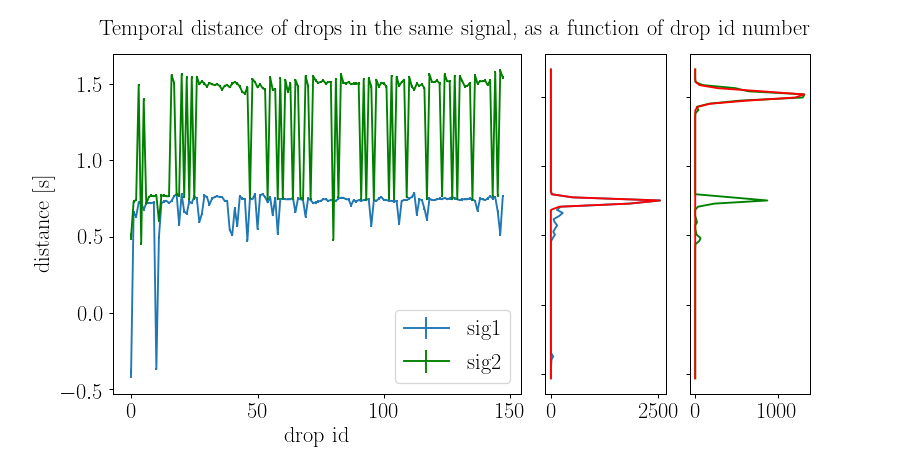

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.89it/s]
<ipython-input-56-bdfbf37a4ac4>:58: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [59]:
title = 'Temporal distance of drops in the same signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'distance [s]'
bins    = 100

t_dist_1 =  (drop_edges_1[0][1:]-drop_edges_1[2][:-1]+drop_edges_1[1][1:]-drop_edges_1[3][:-1])*0.5
t_dist_2 =  (drop_edges_2[0][1:]-drop_edges_2[2][:-1]+drop_edges_2[1][1:]-drop_edges_2[3][:-1])*0.5

f1, t_d_fit_1, sigma_t_d_fit_1, t_d_fit_2, sigma_t_d_fit_2 = double_histo_plot(bins, v_1=t_dist_1, v_2=t_dist_2, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

subname = 'time_dist'
f1.savefig(f'{plot_dir}/{name}_{subname}.png')

fit_dict['Temporal distance 1 [s]'] = np.array([t_d_fit_1, sigma_t_d_fit_1])
fit_dict['Temporal distance 2 [s]'] = np.array([t_d_fit_2, sigma_t_d_fit_2])

### temporal size

<IPython.core.display.Javascript object>


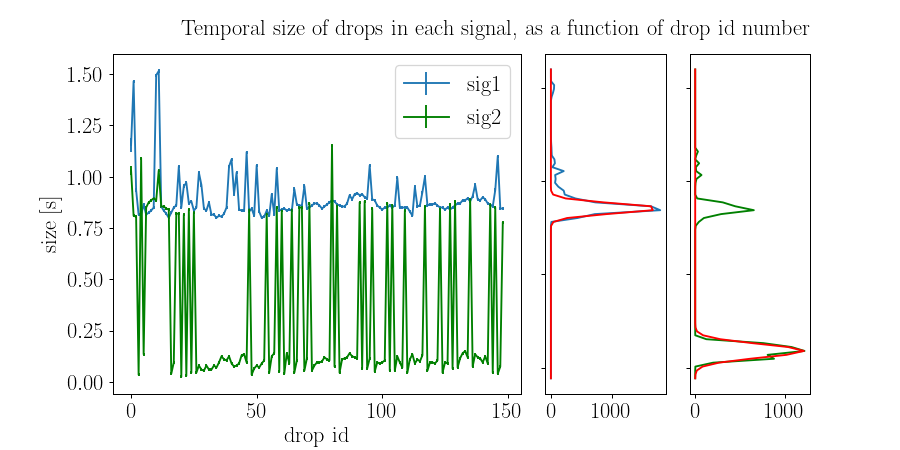

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:03<00:00, 24.22it/s]
<ipython-input-56-bdfbf37a4ac4>:58: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


In [60]:
title = 'Temporal size of drops in each signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'size [s]'
bins=80

t_size_1 =  (drop_edges_1[2]-drop_edges_1[0]+drop_edges_1[3]-drop_edges_1[1])*0.5
t_size_2 =  (drop_edges_2[2]-drop_edges_2[0]+drop_edges_2[3]-drop_edges_2[1])*0.5

f2, t_s_fit_1, sigma_t_s_fit_1, t_s_fit_2, sigma_t_s_fit_2 = double_histo_plot(bins, v_1=t_size_1, v_2=t_size_2, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

subname = 'time_size'
f2.savefig(f'{plot_dir}/{name}_{subname}.png')

fit_dict['temporal size 1 [s]'] = np.array([t_s_fit_1, sigma_t_s_fit_1])
fit_dict['temporal size 2 [s]'] = np.array([t_s_fit_2, sigma_t_s_fit_2])

### temporal period

In [ ]:
title = 'Temporal period of drops in each signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'period [s]'
bins=60

t_period_1 =  (drop_edges_1[0][1:]-drop_edges_1[0][:-1])*0.25
t_period_2 =  (drop_edges_2[0][1:]-drop_edges_2[0][:-1])*0.25
for i in range(1,4):
    t_period_1 +=  (drop_edges_1[i][1:]-drop_edges_1[i][:-1])*0.25
    t_period_2 +=  (drop_edges_2[i][1:]-drop_edges_2[i][:-1])*0.25

f3, t_p_fit_1, sigma_t_p_fit_1, t_p_fit_2, sigma_t_p_fit_2 = double_histo_plot(bins, v_1=t_period_1, v_2=t_period_2, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

subname = 'time_period'
f3.savefig(f'{plot_dir}/{name}_{subname}.png')

fit_dict['temporal period 1 [s]'] = np.array([t_p_fit_1, sigma_t_p_fit_1])
fit_dict['temporal period 2 [s]'] = np.array([t_p_fit_2, sigma_t_p_fit_2])

### velocity

In [ ]:
bins=80

dt_mid = (drop_edges_2[0]-drop_edges_1[0])*0.25
for i in range(1,4):
    dt_mid += (drop_edges_2[i]-drop_edges_1[i])*0.25    
v_mid = 50/dt_mid

fit_switch=False
subname ='velocity'

f4, dt_1, sigma_dt_1, v_2, sigma_v_2 = dt_vel(bins,dt_mid,v_mid, fit_switch)
f4.savefig(f'{plot_dir}/{name}_{subname}.png')

fit_dict['dt detectors [s]'] = np.array([dt_1, sigma_dt_1])
fit_dict['velocity [s]'] = np.array([v_2, sigma_v_2])


### spatial size

In [ ]:
title = 'Spatial size of drops in each signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'size [mm]'
bins=65

f5, s_s_fit_1, sigma_s_s_fit_1, s_s_fit_2, sigma_s_s_fit_2 = double_histo_plot(bins, v_1=t_size_1*v_mid, v_2=t_size_2*v_mid, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

subname = 'space_size'
f5.savefig(f'{plot_dir}/{name}_{subname}.png')

fit_dict['spatial size 1 [s]'] = np.array([s_s_fit_1, sigma_s_s_fit_1])
fit_dict['spatial size 2 [s]'] = np.array([s_s_fit_2, sigma_s_s_fit_2])

### Space distance

In [ ]:
title = 'Spatial distance of drops in each signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'dstance [mm]'
bins=100

f5b, s_d_fit_1, sigma_s_d_fit_1, s_d_fit_2, sigma_s_d_fit_2 = double_histo_plot(bins, v_1=t_dist_1*(v_mid[:-1]+v_mid[1:])*0.5, v_2=t_dist_2*(v_mid[:-1]+v_mid[1:])*0.5, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

subname = 'space_distance'
f5b.savefig(f'{plot_dir}/{name}_{subname}.png')

fit_dict['spatial distance 1 [s]'] = np.array([s_d_fit_1, sigma_s_d_fit_1])
fit_dict['spatial distance 2 [s]'] = np.array([s_d_fit_2, sigma_s_d_fit_2])

### fiber spatial size

In [ ]:
title = 'Fiber size estimated for each signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'size [mm]'
bins=100

fiber_1 = (drop_edges_1[1]-drop_edges_1[0]+drop_edges_1[3]-drop_edges_1[2])*0.5
fiber_2 = (drop_edges_2[1]-drop_edges_2[0]+drop_edges_2[3]-drop_edges_2[2])*0.5

f6, fiber_fit_1, sigma_fiber_fit_1, fiber_fit_2, sigma_fiber_fit_2 = double_histo_plot(bins, v_1=fiber_1*v_mid, v_2=fiber_2*v_mid, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

subname = 'fiber'
f6.savefig(f'{plot_dir}/{name}_{subname}.png')

fit_dict['fiber spatial size 1 [s]'] = np.array([fiber_fit_1, sigma_fiber_fit_1])
fit_dict['fiber spatial size 2 [s]'] = np.array([fiber_fit_2, sigma_fiber_fit_2])

In [ ]:
title = 'Fiber size estimated for each signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'size [mm]'
bins=100

fiber_1 = drop_edges_1[1]-drop_edges_1[0]
fiber_2 = drop_edges_2[1]-drop_edges_2[0]
%matplotlib notebook
f6, fiber_fit_1, sigma_fiber_fit_1, fiber_fit_2, sigma_fiber_fit_2 = double_histo_plot(bins, v_1=fiber_1*v_mid, v_2=fiber_2*v_mid, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

In [ ]:
title = 'Fiber size estimated for each signal, as a function of drop id number'
xlabel = 'drop id'
ylabel = 'size [mm]'
bins=100

fiber_1 = drop_edges_1[3]-drop_edges_1[2]
fiber_2 = drop_edges_2[3]-drop_edges_2[2]
%matplotlib notebook
f6, fiber_fit_1, sigma_fiber_fit_1, fiber_fit_2, sigma_fiber_fit_2 = double_histo_plot(bins, v_1=fiber_1*v_mid, v_2=fiber_2*v_mid, 
                                                                    title=title, xlabel=xlabel, ylabel=ylabel)

## Save all fit results

In [ ]:
fit_dict

In [ ]:
fit_df = pd.DataFrame(data=[], columns=['property', 'mean', 'mean std', 'sigma', 'sigma std'])
for k,a in fit_dict.items():
    fit_df.loc[len(fit_df)] = [k, a[0].n, a[0].s, a[1].n, a[1].s]

In [ ]:
def safe_save(method, filename, **kwargs):    
    while(os.path.exists(filename)):
        o = input(f'{filename} already exists: overwrite? [y/n] ')
        if o == 'y':
            break
        o = input('Would you like to save with another name? [y/n]')
        if o != 'y':
            return
        filename = input('Type filename: ')
            
    return method(filename, **kwargs)

In [ ]:
save_path = f'{result_dir}/{name}_e.csv'

safe_save(fit_df.to_csv, filename=save_path, index=False)